In [1]:
from sae import Sae, SaeConfig
from scipy.optimize import linear_sum_assignment
import numpy as np
from tqdm import tqdm
from argparse import ArgumentParser
import torch
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_sae(dir, hookpoint, device):
    if "mnt" in dir:
        return Sae.load_from_disk(dir+"/"+hookpoint, device=device)
    else:
        return Sae.load_from_hub(dir, hookpoint=hookpoint, device=device)


## 32k

In [5]:
sae_dir = "EleutherAI/sae-pythia-160m-32k"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-seed2"

sae_32k_seed1 = load_sae(sae_dir, "layers.6.mlp", "cuda:1")
sae_32k_seed2 = load_sae(sae_2_seed_dir, "layers.6.mlp", "cuda:1")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


In [6]:
sae_32k_seed1_weight = sae_32k_seed1.W_dec.data / sae_32k_seed1.W_dec.data.norm(dim=1, keepdim=True)
sae_32k_seed2_weight = sae_32k_seed2.W_dec.data / sae_32k_seed2.W_dec.data.norm(dim=1, keepdim=True)
sae_32k_seed1_encoder_weight = sae_32k_seed1.encoder.weight / sae_32k_seed1.encoder.weight.norm(dim=1, keepdim=True)
sae_32k_seed2_encoder_weight = sae_32k_seed2.encoder.weight / sae_32k_seed2.encoder.weight.norm(dim=1, keepdim=True)

cost_dec = sae_32k_seed1_weight @ sae_32k_seed2_weight.T
cost_enc = sae_32k_seed1_encoder_weight @ sae_32k_seed2_encoder_weight.T
cost_dec = cost_dec.cpu().detach()
cost_enc = cost_enc.cpu().detach()

In [7]:
row_ind_dec,col_ind_dec = pickle.load(open("alignment/indices_decoder_k32-sae-mlp-32k-seed1-seed2.pkl","rb"))[6][6]
row_ind_enc,col_ind_enc = pickle.load(open("alignment/indices_encoder_k32-sae-mlp-32k-seed1-seed2.pkl","rb"))[6][6]



In [8]:
equal = col_ind_enc == col_ind_dec
count_equal = sum(equal)
print("Fraction of features aligned:",count_equal/len(col_ind_enc))
cost_higher_50 = cost_dec.numpy()[row_ind_dec,col_ind_dec] > 0.7
cost_higher_50_enc = cost_enc.numpy()[row_ind_enc,col_ind_enc] > 0.7
count_higher_50 = sum(cost_higher_50 & cost_higher_50_enc)
print("Fraction of features aligned with decoder > 0.5:",count_higher_50/len(col_ind_enc))


Fraction of features aligned: 0.792938232421875
Fraction of features aligned with decoder > 0.5: 0.4158935546875


Text(0, 0.5, 'Number of latents')

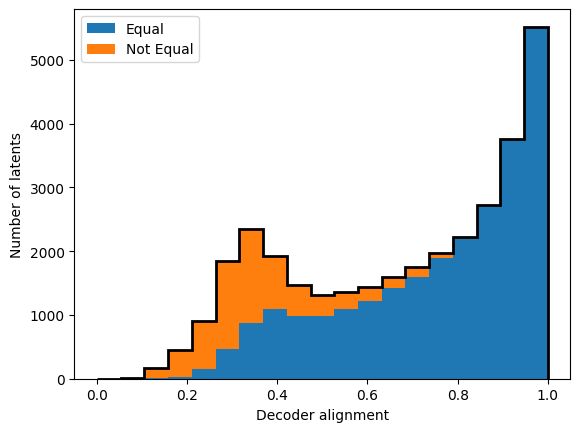

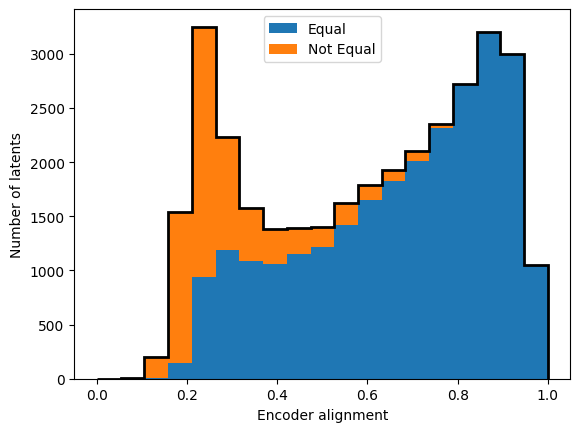

In [51]:
aligned_cost_dec_equal = cost_dec[row_ind_dec,col_ind_dec][equal]
aligned_cost_dec_not_equal = cost_dec[row_ind_dec,col_ind_dec][~equal]

plt.figure()
plt.hist([aligned_cost_dec_equal,aligned_cost_dec_not_equal],bins=np.linspace(0,1,20),label=["Equal","Not Equal"],stacked=True)
plt.hist(cost_dec.numpy()[row_ind_dec,col_ind_dec],bins=np.linspace(0,1,20),fill=False,histtype="step",color="black",linewidth=2)
#plt.yscale("log")
plt.legend()
plt.xlabel("Decoder alignment")
plt.ylabel("Number of latents")

aligned_cost_enc_equal = cost_enc[row_ind_enc,col_ind_enc][equal]
aligned_cost_enc_not_equal = cost_enc[row_ind_enc,col_ind_enc][~equal]

plt.figure()
plt.hist([aligned_cost_enc_equal,aligned_cost_enc_not_equal],bins=np.linspace(0,1,20),label=["Equal","Not Equal"],stacked=True)
plt.hist(cost_enc.numpy()[row_ind_enc,col_ind_enc],bins=np.linspace(0,1,20),fill=False,histtype="step",color="black",linewidth=2)
#plt.yscale("log")
plt.legend()
plt.xlabel("Encoder alignment")
plt.ylabel("Number of latents")

/mnt/ssd-1/gpaulo/miniconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


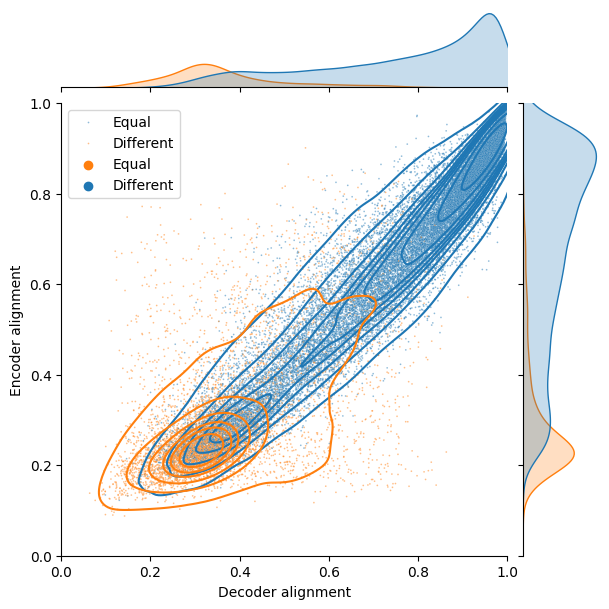

In [52]:
# have a list that says equal in the positions where equal is true and different in the positions where equal is false
equal_list = ["Equal" if e else "Different" for e in equal]


g = sns.jointplot(x=cost_dec.numpy()[row_ind_dec,col_ind_dec],y=cost_enc.numpy()[row_ind_enc,col_ind_enc],hue=equal_list,alpha=0.5,s=1.5)
g.plot_joint(sns.kdeplot,linewidth=2)
plt.scatter(-1,-1,color="C1",label="Equal")
plt.scatter(-1,-1,color="C0",label="Different")

plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.xlabel("Decoder alignment")
plt.ylabel("Encoder alignment")
plt.savefig("equal.svg")

/mnt/ssd-1/gpaulo/miniconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


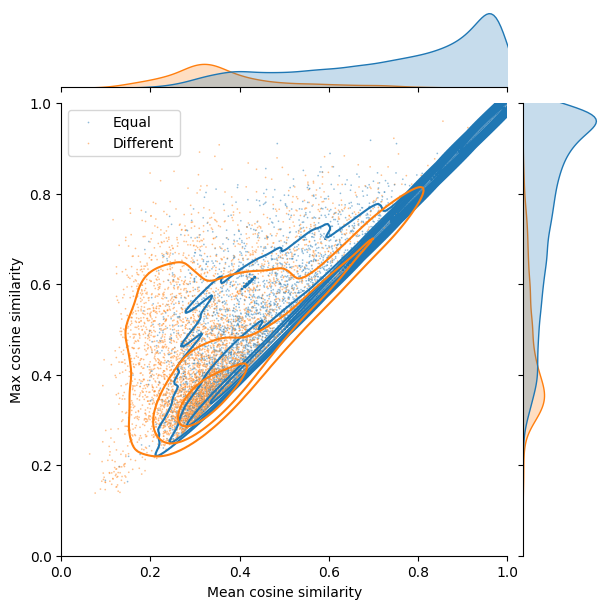

In [87]:
# have a list that says equal in the positions where equal is true and different in the positions where equal is false
equal_list = ["Equal" if e else "Different" for e in equal]

g = sns.jointplot(x=cost_dec.numpy()[row_ind_dec,col_ind_dec],y=np.max(cost_dec.numpy(),axis=1),hue=equal_list,alpha=0.5,s=1.5)
g.plot_joint(sns.kdeplot,linewidth=2)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.xlabel("Mean cosine similarity")
plt.ylabel("Max cosine similarity")
plt.savefig("max_mean.svg")


In [53]:
max_cos_alignment_dec = cost_dec.max(dim=1).values.cpu().numpy()
max_cos_alignment_enc = cost_enc.max(dim=1).values.cpu().numpy()


In [54]:
# line plot with fraction of aligned features depending on the threshold

thresholds = np.linspace(0,1,50)
aligned_features = []
aligned_features_equal = []
max_cosine_sim = []
for threshold in thresholds:
    # get the features that are higher than the threshold on both the decoder and the encoder
    cost_higher_threshold = cost_dec.numpy()[row_ind_dec,col_ind_dec] > threshold
    cost_higher_threshold_enc = cost_enc.numpy()[row_ind_enc,col_ind_enc] > threshold
    # get the features that are aligned
    aligned_features_threshold = cost_higher_threshold & cost_higher_threshold_enc
    count_aligned_features_threshold = sum(aligned_features_threshold)
    aligned_features.append(count_aligned_features_threshold/len(col_ind_enc))
    # check also if the features are equal
    aligned_features_equal_threshold = equal & cost_higher_threshold & cost_higher_threshold_enc
    count_aligned_features_equal_threshold = sum(aligned_features_equal_threshold)
    aligned_features_equal.append(count_aligned_features_equal_threshold/len(col_ind_enc))
    # get the max cosine similarity
    cost_max_cos_sim_dec = max_cos_alignment_dec > threshold
    cost_max_cos_sim_enc = max_cos_alignment_enc > threshold
    aligned_features_max_cos_sim = cost_max_cos_sim_dec & cost_max_cos_sim_enc
    count_aligned_features_max_cos_sim = sum(aligned_features_max_cos_sim)
    max_cosine_sim.append(count_aligned_features_max_cos_sim/len(col_ind_enc))




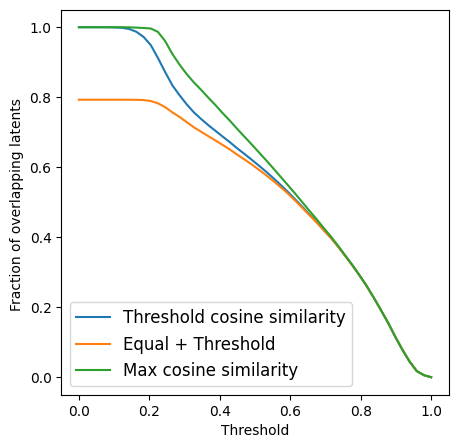

In [59]:

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(thresholds,aligned_features)
ax.plot(thresholds,aligned_features_equal)
ax.plot(thresholds,max_cosine_sim)
# make a small inset plot between x 0.6 and 0.8
# axins = ax.inset_axes([0.1, 0.1, 0.4, 0.4])
# axins.plot(thresholds,aligned_features)
# axins.plot(thresholds,aligned_features_equal)
# axins.plot(thresholds,max_cosine_sim)
# axins.set_xlim(0.6,0.8)
# axins.set_ylim(0.25,0.55)
ax.set_xlabel("Threshold")
ax.set_ylabel("Fraction of overlapping latents ")
ax.legend(["Threshold cosine similarity","Equal + Threshold","Max cosine similarity"],loc="lower left",fontsize=12)
#ax.plot([0.7,0.7],[0,1],color="black",linewidth=1,ls="--")
#ax.plot([0,1],[0.50,0.50],color="black",linewidth=1,ls="--")
plt.savefig("aligned_features.svg")


### Multiple seed comparison  

In [4]:
import os
import pickle
from tqdm import tqdm

In [4]:
sae_seeds = []
for i in range(2,3):
    sae = load_sae(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-seed{i}", "layers.6.mlp", "cpu")
    sae_seeds.append(sae)


In [5]:
all_seeds = [sae_32k_seed1] + sae_seeds


In [6]:
# Normalize weights for all SAEs
sae_decoder_weights = []
sae_encoder_weights = []
for sae_seed in all_seeds:  # Include first SAE
    dec_weight = sae_seed.W_dec.data.to("cuda:6")
    dec_weight = dec_weight / dec_weight.norm(dim=1, keepdim=True)
    sae_decoder_weights.append(dec_weight)
    
    enc_weight = sae_seed.encoder.weight.to("cuda:6") 
    enc_weight = enc_weight / enc_weight.norm(dim=1, keepdim=True)
    sae_encoder_weights.append(enc_weight)

# Compute costs between all pairs
costs = {}
costs_enc = {}
for i in tqdm(range(len(sae_decoder_weights))):
    for j in range(i+1, len(sae_decoder_weights)):
        print(i,j)
        # Compute decoder costs
        cost = sae_decoder_weights[i] @ sae_decoder_weights[j].T
        cost = cost.cpu().detach().numpy()
        costs[(i+1,j+1)] = cost
        
        # Compute encoder costs
        cost_enc = sae_encoder_weights[i] @ sae_encoder_weights[j].T
        cost_enc = cost_enc.cpu().detach().numpy()
        costs_enc[(i+1,j+1)] = cost_enc


  0%|          | 0/9 [00:00<?, ?it/s]

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8


 11%|█         | 1/9 [00:26<03:31, 26.41s/it]

1 2
1 3
1 4
1 5
1 6
1 7
1 8


 22%|██▏       | 2/9 [00:49<02:51, 24.57s/it]

2 3
2 4
2 5
2 6
2 7
2 8


 33%|███▎      | 3/9 [01:09<02:14, 22.41s/it]

3 4
3 5
3 6
3 7
3 8


 44%|████▍     | 4/9 [01:26<01:40, 20.19s/it]

4 5
4 6
4 7
4 8


 56%|█████▌    | 5/9 [01:39<01:10, 17.69s/it]

5 6
5 7
5 8


 67%|██████▋   | 6/9 [01:49<00:45, 15.05s/it]

6 7
6 8


 78%|███████▊  | 7/9 [01:56<00:24, 12.31s/it]

7 8


100%|██████████| 9/9 [01:59<00:00, 13.28s/it]


In [7]:
row_inds = {}
col_inds = {}
row_inds_enc = {}
col_inds_enc = {}
for i in range(1,9):
    for j in range(i+1,10):
        if i == 1 and j == 2:
            row_ind_dec,col_ind_dec = pickle.load(open(f"alignment/indices_decoder_k32-sae-mlp-32k-seed{i}-seed{j}.pkl","rb"))[6][6]
            row_ind_enc,col_ind_enc = pickle.load(open(f"alignment/indices_encoder_k32-sae-mlp-32k-seed{i}-seed{j}.pkl","rb"))[6][6]
        else:
            row_ind_dec,col_ind_dec = pickle.load(open(f"alignment/indices_decoder_k32-sae-mlp-32k-seed{i}-seed{j}.pkl","rb"))[0][6]
            row_ind_enc,col_ind_enc = pickle.load(open(f"alignment/indices_encoder_k32-sae-mlp-32k-seed{i}-seed{j}.pkl","rb"))[0][6]
        row_inds[(i,j)] = row_ind_dec
        col_inds[(i,j)] = col_ind_dec
        row_inds_enc[(i,j)] = row_ind_enc
        col_inds_enc[(i,j)] = col_ind_enc


In [9]:
masks = {}
for i in range(1,10):
    masks[i] = {}
    for j in range(1,10):
        if i == j:
            continue
        if i < j:
            # Use costs[(i,j)] directly
            mask = costs[(i,j)][row_inds[(i,j)], col_inds[(i,j)]] > 0.7
            mask_enc = costs_enc[(i,j)][row_inds_enc[(i,j)], col_inds_enc[(i,j)]] > 0.7
            masks[i][j] = mask & mask_enc
        else:
            masks[i][j] = masks[j][i]
        


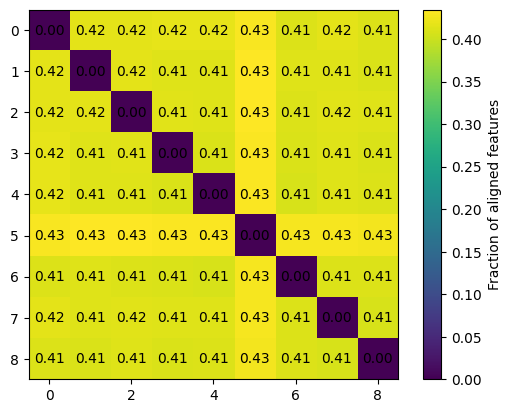

In [176]:
grid = []
for i in range(1,10):
    subgrid = []
    for j in range(1,10):
        if i == j:
            subgrid.append(0)
        else:
            subgrid.append(sum(masks[i][j])/len(masks[i][j]))
    grid.append(subgrid)
grid = np.array(grid)
plt.imshow(grid)
# Add text annotations to each cell
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        plt.text(j, i, f"{grid[i,j]:.2f}", ha='center', va='center')
# add legend to colorbar
cbar = plt.colorbar()
cbar.set_label("Fraction of aligned features")
plt.show()

In [181]:
# Create a copy of the original masks

masks_permuted = {}
for i in range(1,10):
    masks_permuted[i] = {}
    for j in range(1,10):
        if i == j:
            continue
        # When either index is 1 or 6, swap them
        i_new = 6 if i == 1 else (1 if i == 6 else i)
        j_new = 6 if j == 1 else (1 if j == 6 else j)
        masks_permuted[i][j] = masks[i_new][j_new]




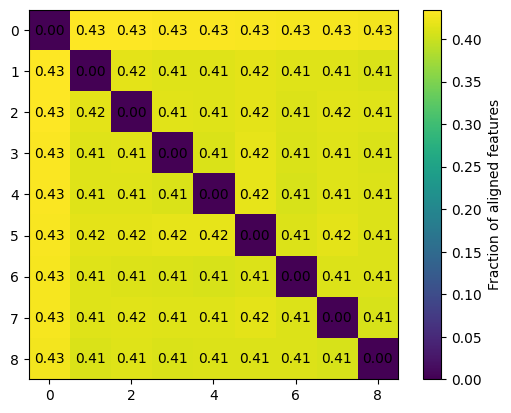

In [182]:
grid = []
for i in range(1,10):
    subgrid = []
    for j in range(1,10):
        if i == j:
            subgrid.append(0)
        else:
            subgrid.append(sum(masks_permuted[i][j])/len(masks_permuted[i][j]))
    grid.append(subgrid)
grid = np.array(grid)
plt.imshow(grid)
# Add text annotations to each cell
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        plt.text(j, i, f"{grid[i,j]:.2f}", ha='center', va='center')
# add legend to colorbar
cbar = plt.colorbar()
cbar.set_label("Fraction of aligned features")
plt.show()

In [260]:
from itertools import combinations

# Create array to store per_level_features for each seed
all_per_level_features = []
number_seeds = 10
for seed in tqdm(range(1,number_seeds)):  # Changed to 1-9 range
    # Create dictionary of base pairs with SAE_seed
    base_pairs = {}
    
    for j in range(1,number_seeds):  # Changed to 1-9 range
        if j == seed:
            continue
       
        if seed < j:
            base_pairs[j] = set(row_inds[(seed,j)][masks[seed][j]])
        else:
            base_pairs[j] = set(col_inds_enc[(j,seed)][masks[seed][j]])
    print(base_pairs.keys())
    def get_intersection(indices):
        """Get intersection of sets for given SAE indices (always including SAE_seed)"""
        result = set.intersection(*[base_pairs[i] for i in indices])
        return result
        
    # Dictionary to store results for each level
    results = {}

    # For each level (2 to 9 SAEs)
    for level in range(2, number_seeds):  # Changed to max 9 SAEs
        # Get all possible combinations for this level
        level_results = {}
        other_saes = [i for i in range(1,number_seeds) if i != seed]  # Changed to 0-8 range
        for combo in combinations(other_saes, level-1):  # -1 because SAE_seed is always included
            intersection = get_intersection(combo)
            key = f"{seed}_{'_'.join(map(str, combo))}"
            level_results[key] = intersection
        results[level] = level_results

    # Calculate exclusive memberships (elements in exactly k SAEs)
    exclusive_counts = {}
    exclusive_members = {}
    for level in range(number_seeds-1, 1, -1):  # Changed to max 9 SAEs
        for key, intersection in results[level].items():
            # Remove elements that appear in higher-level intersections
            if level < number_seeds-1:  # Changed to max 9 SAEs
                for higher_level in range(level + 1, number_seeds):  # Changed to max 9 SAEs
                    for higher_intersection in results[higher_level].values():
                        intersection = intersection - higher_intersection
            exclusive_counts[key] = len(intersection)
            exclusive_members[key] = intersection

    # Elements only in SAE_seed
    only_in_seed = set()
    for i in base_pairs:
        only_in_seed = only_in_seed.union(base_pairs[i])
    only_in_seed = len(set(range(32768)) - only_in_seed)

    # Collect per_level_features for this seed
    seed_per_level_features = []
    for level in range(number_seeds-1, 1, -1):  # Changed to max 9 SAEs
        level_total = 0
        for key, count in exclusive_counts.items():
            if key.count('_') == level-1:  # number of underscores indicates number of SAEs
                level_total += count
        seed_per_level_features.append(level_total)
    seed_per_level_features.append(only_in_seed)
    print(sum(seed_per_level_features))
    all_per_level_features.append(seed_per_level_features)

all_per_level_features = np.array(all_per_level_features)

  0%|          | 0/9 [00:00<?, ?it/s]

dict_keys([2, 3, 4, 5, 6, 7, 8, 9])


 11%|█         | 1/9 [00:00<00:07,  1.08it/s]

32768
dict_keys([1, 3, 4, 5, 6, 7, 8, 9])


 22%|██▏       | 2/9 [00:01<00:06,  1.08it/s]

32768
dict_keys([1, 2, 4, 5, 6, 7, 8, 9])


 33%|███▎      | 3/9 [00:02<00:05,  1.07it/s]

32768
dict_keys([1, 2, 3, 5, 6, 7, 8, 9])


 44%|████▍     | 4/9 [00:03<00:04,  1.07it/s]

32768
dict_keys([1, 2, 3, 4, 6, 7, 8, 9])


 56%|█████▌    | 5/9 [00:04<00:03,  1.06it/s]

32768
dict_keys([1, 2, 3, 4, 5, 7, 8, 9])


 67%|██████▋   | 6/9 [00:05<00:02,  1.04it/s]

32768
dict_keys([1, 2, 3, 4, 5, 6, 8, 9])


 78%|███████▊  | 7/9 [00:06<00:01,  1.05it/s]

32768
dict_keys([1, 2, 3, 4, 5, 6, 7, 9])


 89%|████████▉ | 8/9 [00:07<00:00,  1.06it/s]

32768
dict_keys([1, 2, 3, 4, 5, 6, 7, 8])


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]

32768


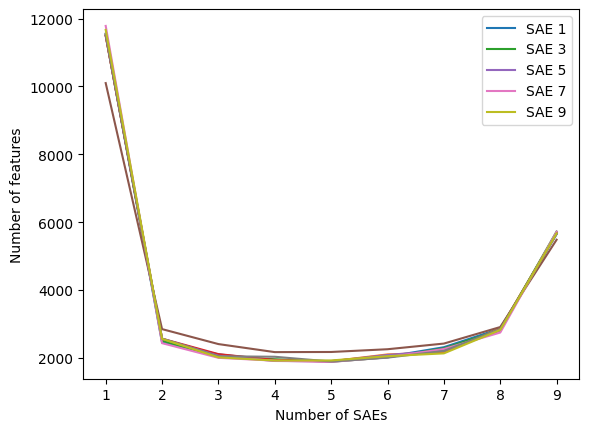

In [261]:
for i in range(all_per_level_features.shape[0]):
    if (i+1)%2 == 0:
        plt.plot(np.arange(1,10),np.flip(all_per_level_features[i]))
    else:
        plt.plot(np.arange(1,10),np.flip(all_per_level_features[i]),label=f"SAE {i+1}")
plt.xlabel("Number of SAEs")
plt.ylabel("Number of features")
#plt.xticks([0,2,4,6,8],["Only in 1 SAE","3 SAEs","5 SAEs","7 SAEs","All SAEs"])
plt.legend()


In [226]:
import plotly.graph_objects as go

In [305]:


fig = go.Figure(data=[go.Pie(labels=["Exactly in 1 SAE","Exactly 2 SAEs","Exactly 3 SAEs","Exactly 4 SAEs","Exactly 5 SAEs","Exactly 6 SAEs","Exactly 7 SAEs","Exactly 8 SAEs","Exactly 9 SAEs","Exactly 10 SAEs","Exactly 11 SAEs","All SAEs"],
                              values=np.flip(np.mean(all_per_level_features,axis=0)),
                              hole=0.5,
                              marker=dict(line=dict(color='black', width=2)))])
fig.update_layout(legend=dict(yanchor="middle",y=0.55,xanchor="center",x=0.85))
fig.show()
fig.write_image("sae_overlap_donut.svg")


In [298]:
from itertools import combinations
number_of_features = []
error_bars = []
error = False
for number_saes in tqdm(range(2,10)):
    # Create dictionary of base pairs with SAE_1
    samples = []
    # make trials based on the combination of i SAEs
    number_of_combinations = 20
    number_seeds = number_saes+1
    start_seed = 1

    for trial in range(number_of_combinations):
        # choose i seeds to be the pairs 
        all_seeds = np.random.choice(range(1,10),number_saes,replace=False)
        # choose the base seed
        base_seed = np.random.choice(all_seeds)
        # remove the base seed from the list
        all_seeds = [s for s in all_seeds if s != base_seed]
        base_pairs = {}
        for j in all_seeds:
            if base_seed < j:
                base_pairs[j] = set(row_inds[(base_seed,j)][masks[base_seed][j]])
            else:
                base_pairs[j] = set(col_inds_enc[(j,base_seed)][masks[base_seed][j]])
        
        def get_intersection(indices):
            """Get intersection of sets for given SAE indices (always including SAE_seed)"""
            result = set.intersection(*[base_pairs[i] for i in indices])
            return result
        
        # Dictionary to store results for each level
        results = {}

        # For each level (2 to 9 SAEs)
        for level in range(2, number_seeds):  # Changed to max 9 SAEs
            # Get all possible combinations for this level
            level_results = {}
            other_saes = all_seeds
            for combo in combinations(other_saes, level-1):  # -1 because SAE_seed is always included
                intersection = get_intersection(combo)
                key = f"{base_seed}_{'_'.join(map(str, combo))}"
                level_results[key] = intersection
            results[level] = level_results

        # Calculate exclusive memberships (elements in exactly k SAEs)
        exclusive_counts = {}
        exclusive_members = {}
        for level in range(number_seeds-1, 1, -1):  # Changed to max 9 SAEs
            for key, intersection in results[level].items():
                # Remove elements that appear in higher-level intersections
                if level < number_seeds-1:  # Changed to max 9 SAEs
                    for higher_level in range(level + 1, number_seeds):  # Changed to max 9 SAEs
                        for higher_intersection in results[higher_level].values():
                            intersection = intersection - higher_intersection
                exclusive_counts[key] = len(intersection)
                exclusive_members[key] = intersection

        # Elements only in SAE_seed
        only_in_seed = set()
        for i in base_pairs:
            only_in_seed = only_in_seed.union(base_pairs[i])
        only_in_seed = len(set(range(32768))  - only_in_seed)

        # Collect per_level_features for this seed
        seed_per_level_features = []
        for level in range(number_seeds-1, 1, -1):  # Changed to max 9 SAEs
            level_total = 0
            for key, count in exclusive_counts.items():
                if key.count('_') == level-1:  # number of underscores indicates number of SAEs
                    level_total += count
            seed_per_level_features.append(level_total)
        seed_per_level_features.append(only_in_seed)
        samples.append(only_in_seed/32768)
        if sum(seed_per_level_features) != 32768:
            print(sum(seed_per_level_features))
            error = True
            break
    if error:
        break
    number_of_features.append(np.mean(samples))
    error_bars.append(np.std(samples))
        

100%|██████████| 8/8 [00:31<00:00,  3.91s/it]


NameError: name 'number_of_features' is not defined

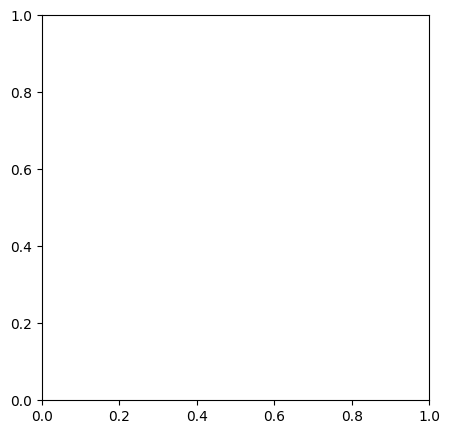

In [95]:
x = np.array([2,3,4,5,6,7,8,9])
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x,number_of_features,ls="",marker="o")
ax.errorbar(x,number_of_features,yerr=error_bars,ls="",marker="o")
ax.set_ylim(0.3,0.7)
ax.set_xlabel("Number of SAEs")
ax.set_ylabel("Proportion of features only in one SAE")
fig.savefig("sae_overlap_line.svg")
# fit a power law curve
# from scipy.optimize import curve_fit
# def power_law(x, a, b,c):
#     return a * x**b + c 
# def exponential(x,a,b,c):
#     return a*np.exp(-b*x)+c
# fitting_points = number_of_features
# fitting_x = x
# popt, pcov = curve_fit(power_law, fitting_x, fitting_points,p0=[0.72,-0.35,0.])
# ax[0].plot(x,power_law(x,*popt),color="black",ls="--",label=f"a={popt[0]:.2f}, b={popt[1]:.2f}, c={popt[2]:.2f}")
# popt_exp, pcov_exp = curve_fit(exponential, fitting_x, fitting_points,p0=[0.7,0.44,0.32])
# ax[0].plot(x,exponential(x,*popt_exp),color="red",ls="--",label=f"a={popt_exp[0]:.2f}, b={popt_exp[1]:.2f}, c={popt_exp[2]:.2f}")
# ax[0].legend()
# #ax[0].set_yscale("log") 
# #ax[0].set_xscale("log")
# #plot the residuals
# ax[1].plot(x,np.array(number_of_features)-power_law(x,*popt),color="black",ls="",marker="o")
# ax[1].plot(x,np.array(number_of_features)-exponential(x,*popt_exp),color="red",ls="",marker="o")
# ax[1].set_xlabel("Number of SAEs")
# ax[1].set_ylabel("Residuals")
# ax[1].set_ylim(-0.05,0.05)

# # estimate how many SAEs are needed to have the proportion of features only in SAE-1 below 0.01
# plt.plot(np.logspace(0,7,50),power_law(np.logspace(0,7,50),*popt))
# plt.plot(np.logspace(0,7,50),exponential(np.logspace(0,7,50),*popt_exp))
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Number of SAEs")
# plt.ylabel("Proportion of features only in SAE-1")
# plt.show()


In [307]:
import blobfile
from safetensors.numpy import load_file

In [308]:
def load_locations(path):
    all_locations = []
    for file in blobfile.listdir(path):
        if file.endswith(".safetensors"):
            split_data = load_file(f"{path}/{file}")
            locations = torch.tensor(split_data["locations"].astype(np.int64))
            valid_range = file.split("_")[0]
            locations[:,2] = locations[:,2]+int(valid_range)
            all_locations.append(locations)
    return torch.cat(all_locations)

In [309]:
raw_features_sae_path = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/raw_features/pythia_pile/SAE/.gpt_neox.layers.6.mlp"

locations_sae = load_locations(raw_features_sae_path)

print(locations_sae.shape)


torch.Size([319815680, 3])


In [310]:
# count unique values
sorted_locations_sae = locations_sae[locations_sae[:,2].sort()[1]]

index_sae,counts_sae = torch.unique_consecutive(sorted_locations_sae[:,2],return_counts=True)

real_counts_sae = torch.zeros(32768,dtype = counts_sae.dtype)
real_counts_sae[index_sae] = counts_sae


In [318]:
from itertools import combinations

seed = 1
# Create dictionary of base pairs with SAE_seed
base_pairs = {}

for j in range(1,number_seeds):  # Changed to 1-9 range
    if j == seed:
        continue
    
    if seed < j:
        base_pairs[j] = set(row_inds[(seed,j)][masks[seed][j]])
    else:
        base_pairs[j] = set(col_inds_enc[(j,seed)][masks[seed][j]])
print(base_pairs.keys())
def get_intersection(indices):
    """Get intersection of sets for given SAE indices (always including SAE_seed)"""
    result = set.intersection(*[base_pairs[i] for i in indices])
    return result
    
# Dictionary to store results for each level
results = {}

# For each level (2 to 9 SAEs)
for level in range(2, number_seeds):  # Changed to max 9 SAEs
    # Get all possible combinations for this level
    level_results = {}
    other_saes = [i for i in range(1,number_seeds) if i != seed]  # Changed to 0-8 range
    for combo in combinations(other_saes, level-1):  # -1 because SAE_seed is always included
        intersection = get_intersection(combo)
        key = f"{seed}_{'_'.join(map(str, combo))}"
        level_results[key] = intersection
    results[level] = level_results

# Calculate exclusive memberships (elements in exactly k SAEs)
exclusive_counts = {}
exclusive_members = {}
for level in range(number_seeds-1, 1, -1):  # Changed to max 9 SAEs
    for key, intersection in results[level].items():
        # Remove elements that appear in higher-level intersections
        if level < number_seeds-1:  # Changed to max 9 SAEs
            for higher_level in range(level + 1, number_seeds):  # Changed to max 9 SAEs
                for higher_intersection in results[higher_level].values():
                    intersection = intersection - higher_intersection
        exclusive_counts[key] = len(intersection)
        exclusive_members[key] = intersection

# Elements only in SAE_seed
only_in_seed = set()
for i in base_pairs:
    only_in_seed = only_in_seed.union(base_pairs[i])
only_in_seed = list(set(range(32768)) - only_in_seed)
only_in_seed_number = len(only_in_seed)
# Collect per_level_features for this seed
seed_per_level_features = []
for level in range(number_seeds-1, 1, -1):  # Changed to max 9 SAEs
    level_total = 0
    for key, count in exclusive_counts.items():
        if key.count('_') == level-1:  # number of underscores indicates number of SAEs
            level_total += count
    seed_per_level_features.append(level_total)
seed_per_level_features.append(only_in_seed_number)
print(sum(seed_per_level_features))

dict_keys([2, 3, 4, 5, 6, 7, 8, 9])
32768


In [329]:
# now do the plot for all the levels
all_keys = list(exclusive_members.keys())
all_level_keys = []
for i in range(1,9):
    current_level_keys = []
    # if the key has i underscores, add it to the list
    for key in all_keys:
        if key.count('_') == i:
            current_level_keys.append(key)
    all_level_keys.append(current_level_keys)


In [330]:
all_level_keys

[['1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '1_9'],
 ['1_2_3',
  '1_2_4',
  '1_2_5',
  '1_2_6',
  '1_2_7',
  '1_2_8',
  '1_2_9',
  '1_3_4',
  '1_3_5',
  '1_3_6',
  '1_3_7',
  '1_3_8',
  '1_3_9',
  '1_4_5',
  '1_4_6',
  '1_4_7',
  '1_4_8',
  '1_4_9',
  '1_5_6',
  '1_5_7',
  '1_5_8',
  '1_5_9',
  '1_6_7',
  '1_6_8',
  '1_6_9',
  '1_7_8',
  '1_7_9',
  '1_8_9'],
 ['1_2_3_4',
  '1_2_3_5',
  '1_2_3_6',
  '1_2_3_7',
  '1_2_3_8',
  '1_2_3_9',
  '1_2_4_5',
  '1_2_4_6',
  '1_2_4_7',
  '1_2_4_8',
  '1_2_4_9',
  '1_2_5_6',
  '1_2_5_7',
  '1_2_5_8',
  '1_2_5_9',
  '1_2_6_7',
  '1_2_6_8',
  '1_2_6_9',
  '1_2_7_8',
  '1_2_7_9',
  '1_2_8_9',
  '1_3_4_5',
  '1_3_4_6',
  '1_3_4_7',
  '1_3_4_8',
  '1_3_4_9',
  '1_3_5_6',
  '1_3_5_7',
  '1_3_5_8',
  '1_3_5_9',
  '1_3_6_7',
  '1_3_6_8',
  '1_3_6_9',
  '1_3_7_8',
  '1_3_7_9',
  '1_3_8_9',
  '1_4_5_6',
  '1_4_5_7',
  '1_4_5_8',
  '1_4_5_9',
  '1_4_6_7',
  '1_4_6_8',
  '1_4_6_9',
  '1_4_7_8',
  '1_4_7_9',
  '1_4_8_9',
  '1_5_6_7',
  '1_5_6_8',
  '1_5_6

In [332]:
exclusive_members[all_level_keys[0][0]]

{1,
 99,
 319,
 340,
 593,
 602,
 618,
 959,
 1233,
 1238,
 1281,
 1474,
 1551,
 1783,
 1885,
 2087,
 2124,
 2138,
 2179,
 2183,
 2200,
 2238,
 2242,
 2413,
 2472,
 2503,
 2541,
 2656,
 3055,
 3111,
 3149,
 3241,
 3277,
 3311,
 3474,
 3595,
 3708,
 3845,
 3879,
 3919,
 4032,
 4085,
 4282,
 4346,
 4373,
 4379,
 4389,
 4669,
 4685,
 4862,
 4959,
 4971,
 5082,
 5237,
 5327,
 5399,
 5617,
 6012,
 6091,
 6294,
 6332,
 6439,
 6607,
 6708,
 7009,
 7046,
 7205,
 7244,
 7518,
 7526,
 7560,
 7697,
 7764,
 7813,
 7829,
 7971,
 7993,
 8081,
 8087,
 8154,
 8155,
 8166,
 8382,
 8631,
 8763,
 8987,
 9058,
 9093,
 9124,
 9431,
 9476,
 9551,
 9639,
 9702,
 9765,
 9846,
 9850,
 9912,
 9945,
 10022,
 10157,
 10206,
 10263,
 10265,
 10275,
 10485,
 10570,
 10808,
 10842,
 10879,
 10884,
 11122,
 11233,
 11282,
 11449,
 11530,
 11646,
 11675,
 11725,
 11852,
 11920,
 11972,
 11992,
 12133,
 12139,
 12165,
 12201,
 12277,
 12367,
 12524,
 12544,
 12776,
 13151,
 13165,
 13294,
 13336,
 13381,
 13406,
 13623

In [337]:
seed_per_level_features

[5647, 2864, 2314, 2036, 1908, 1932, 2104, 2451, 11512]

/tmp/ipykernel_2127313/2818560558.py:63: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



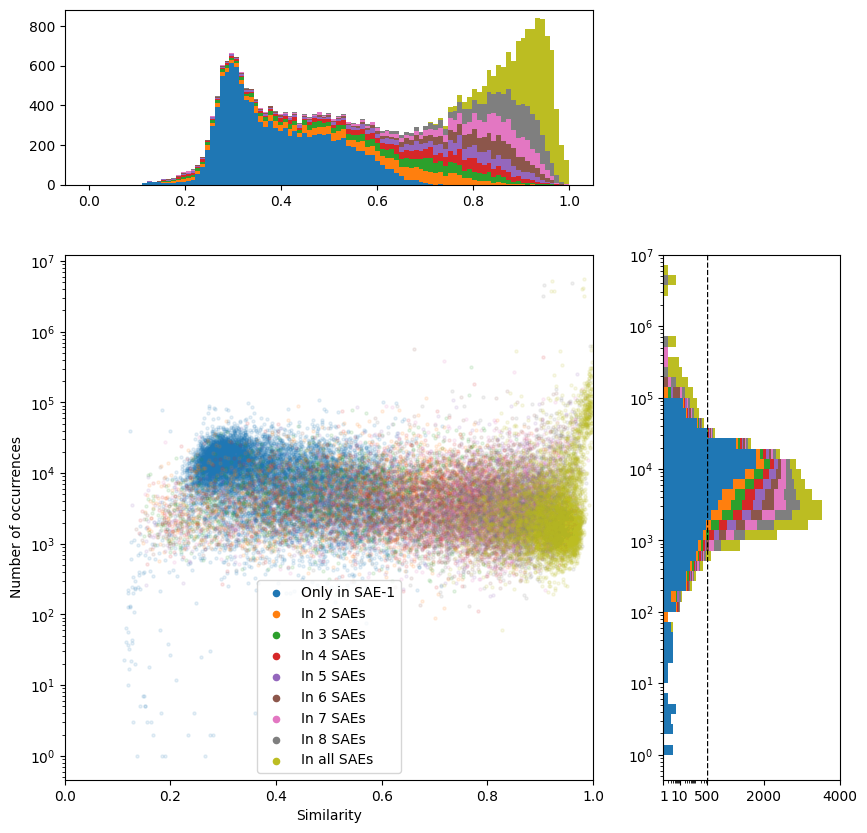

In [394]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and GridSpec
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])

# Create the three subplots
ax_top = fig.add_subplot(gs[0, 0])    # Top histogram
ax_right = fig.add_subplot(gs[1, 1])  # Right histogram
ax_main = fig.add_subplot(gs[1, 0])   # Main scatter plot

only_in_seed= list(only_in_seed)

only_in_sae1_counts = real_counts_sae[only_in_seed]
only_in_sae1_costs = []
for i in range(1,10):
    if i == seed:
        continue
    costs_d = costs[(seed,i)][row_inds[(seed,i)],col_inds[(seed,i)]] 
    costs_e = costs_enc[(seed,i)][row_inds_enc[(seed,i)],col_inds_enc[(seed,i)]]
    only_in_sae1_costs.append(0.5*(costs_d+costs_e)[only_in_seed])
only_in_sae1_costs = np.array(only_in_sae1_costs)
only_in_sae1_costs = np.mean(only_in_sae1_costs,axis=0)

only_in_sae1_counts = real_counts_sae[only_in_seed].cpu().numpy()

ax_main.scatter(only_in_sae1_costs,only_in_sae1_counts,s=5,alpha=0.1,c="C0")
ax_main.scatter(-1,-1,s=20,c="C0",label="Only in SAE-1")


all_counts = [only_in_sae1_counts]
all_costs = [only_in_sae1_costs]

colors = ["C0"]
for i in range(0,8):
    # get all the features that are only in i SAEs
    only_in_i_saes = all_level_keys[i]
    this_level_indices = set()
    for key in only_in_i_saes:
        this_level_indices = this_level_indices.union(exclusive_members[key])
    this_level_indices = np.array(list(this_level_indices))
    costs_d = costs[(seed,i+2)][row_inds[(seed,i+2)],col_inds[(seed,i+2)]] 
    costs_e = costs_enc[(seed,i+2)][row_inds_enc[(seed,i+2)],col_inds_enc[(seed,i+2)]]
    only_in_i_saes_costs = 0.5*(costs_d+costs_e)[this_level_indices]
    this_level_counts = real_counts_sae[this_level_indices].cpu().numpy()
    ax_main.scatter(only_in_i_saes_costs,this_level_counts,s=5,alpha=0.1,c="C{}".format(i+1))
    if i < 7:
        ax_main.scatter(-1,-1,s=20,c="C{}".format(i+1),label="In {} SAEs".format(i+2))
    else:
        ax_main.scatter(-1,-1,s=20,c="C{}".format(i+1),label="In all SAEs".format(i+2))
    all_counts.append(this_level_counts)
    all_costs.append(only_in_i_saes_costs)
    colors.append("C{}".format(i+1))
ax_main.set_yscale("log")


ax_right.hist(all_counts, bins=np.logspace(0,7,50), orientation='horizontal',color=colors,histtype="barstacked")
ax_right.set_yscale("log")
ax_right.set_xlim(500,4000)
ax_right.set_xticks([2000,4000])
ax_right.set_xticklabels(["2000","4000"])
ax_right.set_ylim(0,10000000)
ax_right.plot([500,500],[0,100000000],color="black",linewidth=1,ls="--")
ax_right.spines["left"].set_visible(False)
ax_right.yaxis.set_ticks_position('right')
ax_right.yaxis.set_visible(False)

divider = make_axes_locatable(ax_right)
ax_lin = divider.append_axes("left", size="33%", pad=0,sharey=ax_right)
ax_lin.hist(all_counts,bins=np.logspace(0,7,50),color=colors,orientation="horizontal",histtype="barstacked")
ax_lin.set_xlim(1,500)
ax_lin.set_yscale("log")
ax_lin.set_xscale("log")
ax_lin.tick_params(axis='x', which='minor', bottom=True, top=False, labelbottom=False)
ax_lin.spines["right"].set_visible(False)
ax_lin.set_xticks([1,10,500])
ax_lin.set_xticklabels(["1","10","500"])

ax_main.set_ylabel("Number of occurrences")
ax_main.set_xlabel("Similarity")
ax_main.legend()
ax_main.set_xlim(0,1)

ax_top.hist(all_costs,bins=np.linspace(0,1,100),color=colors,histtype="barstacked")

plt.savefig("sae_overlap_frequency.svg",dpi=300)

In [9]:
scores_32k = pd.read_csv("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/results/scores_layer6_recall_SAE.csv")
scores_32k_seed2 = pd.read_csv("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/results/scores_layer6_recall_SAE-2-seed.csv")

In [10]:
all_scores_seed1 = np.zeros(32768)
latents = scores_32k["feature"]
all_scores_seed1[latents.values] = scores_32k["balanced_accuracy"].values
all_other_scores = np.zeros(32768)
latents = scores_32k_seed2["feature"]
all_other_scores[latents.values] = scores_32k_seed2["balanced_accuracy"].values
all_other_scores = all_other_scores[col_ind_dec]

# where all_scores is 0 set all_other_scores to 0
#all_scores_seed1[all_other_scores == 0] = 0
# where all_other_scores is 0 set all_scores to 0
all_other_scores[all_scores_seed1 == 0] = 0

all_scores = (all_scores_seed1)


# #quantiles 
q25, q50, q75 = np.percentile(all_scores[all_scores > 0], [25, 50, 75])
print(q25,q50,q75)
low_scores = (all_scores < q25) & (all_scores > 0)
high_scores = all_scores > q75
average_scores = (all_scores >= q25) & (all_scores <= q75) & (all_scores > 0)
no_scores = all_scores == 0



0.615 0.71 0.7981290217645444


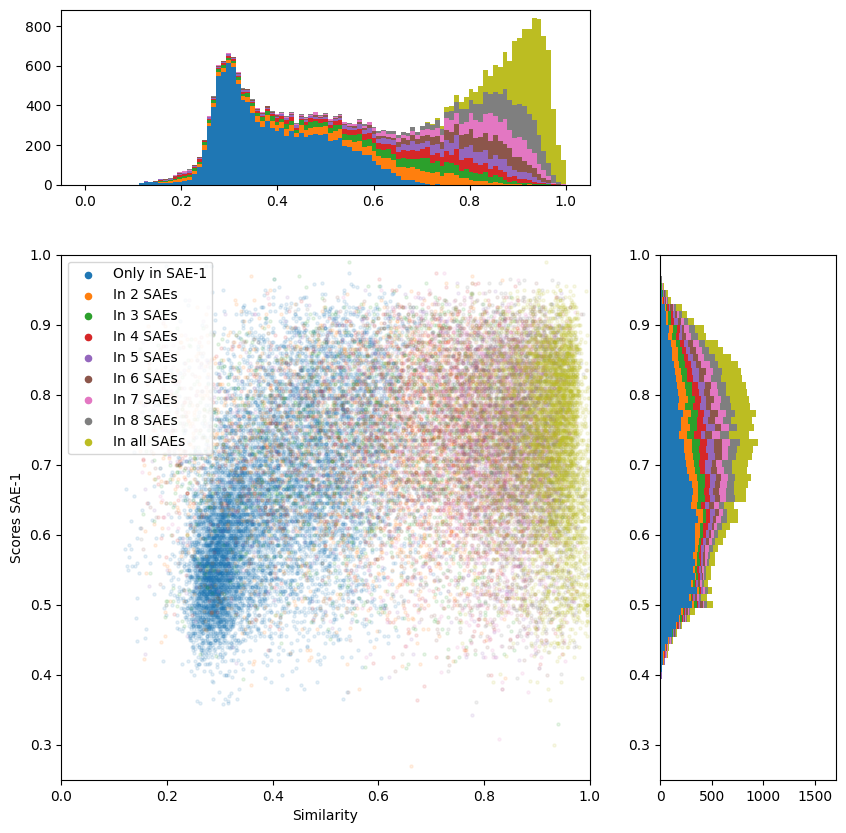

In [395]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and GridSpec
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])

# Create the three subplots
ax_top = fig.add_subplot(gs[0, 0])    # Top histogram
ax_right = fig.add_subplot(gs[1, 1])  # Right histogram
ax_main = fig.add_subplot(gs[1, 0])   # Main scatter plot

only_in_seed= list(only_in_seed)

only_in_sae1_counts = real_counts_sae[only_in_seed]
only_in_sae1_costs = []
for i in range(1,10):
    if i == seed:
        continue
    costs_d = costs[(seed,i)][row_inds[(seed,i)],col_inds[(seed,i)]] 
    costs_e = costs_enc[(seed,i)][row_inds_enc[(seed,i)],col_inds_enc[(seed,i)]]
    only_in_sae1_costs.append(0.5*(costs_d+costs_e)[only_in_seed])
only_in_sae1_costs = np.array(only_in_sae1_costs)
only_in_sae1_costs = np.mean(only_in_sae1_costs,axis=0)

only_in_sae1_counts = all_scores_seed1[only_in_seed]

ax_main.scatter(only_in_sae1_costs,only_in_sae1_counts,s=5,alpha=0.1,c="C0")
ax_main.scatter(-1,-1,s=20,c="C0",label="Only in SAE-1")


all_counts = [only_in_sae1_counts]
all_costs = [only_in_sae1_costs]

colors = ["C0"]
for i in range(0,8):
    # get all the features that are only in i SAEs
    only_in_i_saes = all_level_keys[i]
    this_level_indices = set()
    for key in only_in_i_saes:
        this_level_indices = this_level_indices.union(exclusive_members[key])
    this_level_indices = np.array(list(this_level_indices))
    costs_d = costs[(seed,i+2)][row_inds[(seed,i+2)],col_inds[(seed,i+2)]] 
    costs_e = costs_enc[(seed,i+2)][row_inds_enc[(seed,i+2)],col_inds_enc[(seed,i+2)]]
    only_in_i_saes_costs = 0.5*(costs_d+costs_e)[this_level_indices]
    this_level_counts = all_scores_seed1[this_level_indices]
    ax_main.scatter(only_in_i_saes_costs,this_level_counts,s=5,alpha=0.1,c="C{}".format(i+1))
    if i < 7:
        ax_main.scatter(-1,-1,s=20,c="C{}".format(i+1),label="In {} SAEs".format(i+2))
    else:
        ax_main.scatter(-1,-1,s=20,c="C{}".format(i+1),label="In all SAEs".format(i+2))
    all_counts.append(this_level_counts)
    all_costs.append(only_in_i_saes_costs)
    colors.append("C{}".format(i+1))


ax_right.hist(all_counts, bins=np.linspace(0,1,100), orientation='horizontal',color=colors,histtype="barstacked")
ax_right.set_ylim(0.25,1)
ax_main.set_ylabel("Scores SAE-1")
ax_main.set_xlabel("Similarity")
ax_main.legend()
ax_main.set_xlim(0,1)
ax_main.set_ylim(0.25,1)

ax_top.hist(all_costs,bins=np.linspace(0,1,100),color=colors,histtype="barstacked")

plt.savefig("sae_overlap_scores.svg",dpi=300)

In [156]:
plt.hist(all_counts, bins=np.linspace(0,1,100),color=colors,histtype="barstacked")
for i in range(0,8):
    if i < 7:
        plt.scatter(-1,-1,s=20,c="C{}".format(i+1),label="In {} SAEs".format(i+2))
    else:
        plt.scatter(-1,-1,s=20,c="C{}".format(i+1),label="In all SAEs".format(i+2))
plt.xlim(0.25,1)
plt.ylim(0,1200)
plt.legend()
plt.xlabel("Scores SAE-1")
plt.ylabel("Number of occurrences")
plt.savefig("sae_scores_hist.svg",dpi=300)


NameError: name 'all_counts' is not defined

: 

In [13]:
# not the correct count, correct count is 5901
len(all_scores_seed1[all_scores_seed1 > 0])

31138

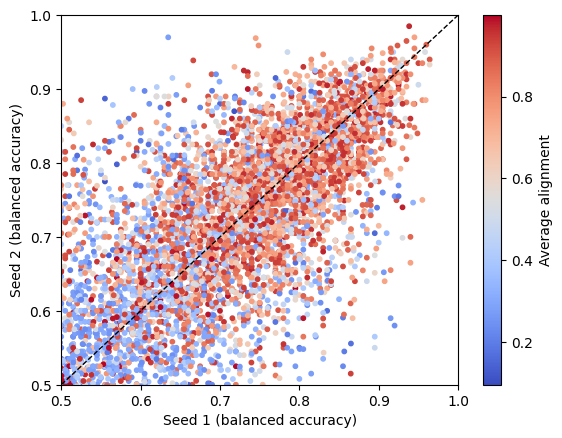

In [155]:
cost_12 = cost_dec[row_ind_dec,col_ind_dec] 
cost_12_enc = cost_enc[row_ind_enc,col_ind_enc]
plt.scatter(all_scores_seed1[all_scores_seed1 > 0],all_other_scores[all_scores_seed1 > 0],c=(cost_12[all_scores_seed1 > 0]+cost_12_enc[all_scores_seed1 > 0])/2,s=10,cmap="coolwarm")
plt.plot([0.5,1],[0.5,1],color="black",linewidth=1,ls="--")
plt.ylim(0.5,1)
plt.xlim(0.5,1)
plt.xlabel("Seed 1 (balanced accuracy)")
plt.ylabel("Seed 2 (balanced accuracy)")
plt.colorbar(label="Average alignment")
plt.savefig("sae_scores_scatter.svg",dpi=300)

In [152]:
# select features from the different quantiles of alignment
quantiles = [0,0.2,0.4,0.6,0.8,1]
selected_features = []
selected_scores_1 = []
selected_scores_2 = []
alignment = []
for i in range(0,len(quantiles)-1):
    features_bin = ((cost_12 + cost_12_enc)/2 > quantiles[i]) & ((cost_12 + cost_12_enc)/2 < quantiles[i+1]) & (all_scores_seed1 > 0) & (all_other_scores > 0)
    indices = np.where(features_bin)[0]
    # 
    accepted_scores = all_scores_seed1[indices]
    other_scores = all_other_scores[indices]

    
    
    top_score = np.argmax(accepted_scores + other_scores * (1 if quantiles[i] >= 0.6 else -1))
    alignment.append((cost_12[indices[top_score]]+cost_12_enc[indices[top_score]])/2)
    selected_features.append(indices[top_score])
    selected_scores_1.append(all_scores_seed1[indices[top_score]])
    selected_scores_2.append(all_other_scores[indices[top_score]])

    #selected_features.append(all_scores_seed1[all_scores_seed1 > 0][cost_12[all_scores_seed1 > 0] > quantiles[i]])


In [153]:
print(selected_features)
print(col_ind_dec[selected_features])
print(alignment)
print(selected_scores_1)
print(selected_scores_2)

[12314, 21463, 5888, 14931, 1817]
[6026 3361 6649 5456   66]
[tensor(0.1947), tensor(0.2653), tensor(0.4391), tensor(0.7540), tensor(0.9694)]
[0.785, 0.91, 0.85, 0.945, 0.938354723332632]
[0.45, 0.455, 0.49, 0.97, 0.985]


In [16]:
import json

In [17]:
with open("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/results/explanations_layer6_SAE.json","r") as f:
    explanations_32k = json.load(f)
with open("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/transcoders/results/explanations_layer6_SAE-2-seed.json","r") as f:
    explanations_32k_seed2 = json.load(f)



In [18]:
explanations_32k

{'0': "'Various linguistic elements, such as suffixes, prefixes, and single characters, that appear to be part of a word, often used to form comparative or verb forms, or to indicate possession, in multiple languages including Russian, Greek, and Polish.'",
 '1': "'Transitional words and phrases that introduce cause-and-effect relationships, indicate a consequence, or provide additional information.'",
 '2': "'Access modifiers, keywords and declarations in programming languages, including public, private, static, virtual, const, and others.'",
 '3': "'Units of time, quantities, or sequence indicators often paired with a preceding number.'",
 '4': "'Punctuation marks used in programming and coding syntax, including comment delimiters, quotation marks, and mathematical operators.'",
 '5': "'Punctuation marks and common function words, often serving grammatical purposes.'",
 '6': "'Mathematical expressions or results, often presented after a calculation or conversion, typically denoted by

In [19]:
from sentence_transformers import SentenceTransformer


explanations_seed1 = list(explanations_32k.values())
explanations_seed2 = list(explanations_32k_seed2.values())
model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True).cuda()

seed1_embeddings = model.encode(explanations_seed1)
seed2_embeddings = model.encode(explanations_seed2)

In [23]:
latents

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', 

In [94]:
all_embedings_seed1 = np.zeros((32768,1024))
latents = [int(i) for i in explanations_32k.keys()]
all_embedings_seed1[latents] = seed1_embeddings
all_embedings_seed2_not_aligned = np.zeros((32768,1024))
latents = [int(i) for i in explanations_32k_seed2.keys()]

all_embedings_seed2_not_aligned[latents] = seed2_embeddings
all_embedings_seed2_aligned = all_embedings_seed2_not_aligned[col_ind_dec]



In [95]:
cost_embeddings_not_aligned = all_embedings_seed1 @ all_embedings_seed2_not_aligned.T / (np.linalg.norm(all_embedings_seed1,axis=1)*np.linalg.norm(all_embedings_seed2_not_aligned,axis=1))
cost_embeddings_aligned = all_embedings_seed1 @ all_embedings_seed2_aligned.T / (np.linalg.norm(all_embedings_seed1,axis=1)*np.linalg.norm(all_embedings_seed2_aligned,axis=1))

/tmp/ipykernel_865456/4056210156.py:1: RuntimeWarning: divide by zero encountered in divide
  cost_embeddings_not_aligned = all_embedings_seed1 @ all_embedings_seed2_not_aligned.T / (np.linalg.norm(all_embedings_seed1,axis=1)*np.linalg.norm(all_embedings_seed2_not_aligned,axis=1))
/tmp/ipykernel_865456/4056210156.py:1: RuntimeWarning: invalid value encountered in divide
  cost_embeddings_not_aligned = all_embedings_seed1 @ all_embedings_seed2_not_aligned.T / (np.linalg.norm(all_embedings_seed1,axis=1)*np.linalg.norm(all_embedings_seed2_not_aligned,axis=1))
/tmp/ipykernel_865456/4056210156.py:2: RuntimeWarning: divide by zero encountered in divide
  cost_embeddings_aligned = all_embedings_seed1 @ all_embedings_seed2_aligned.T / (np.linalg.norm(all_embedings_seed1,axis=1)*np.linalg.norm(all_embedings_seed2_aligned,axis=1))
/tmp/ipykernel_865456/4056210156.py:2: RuntimeWarning: invalid value encountered in divide
  cost_embeddings_aligned = all_embedings_seed1 @ all_embedings_seed2_aligne

In [96]:
cost_diagonal_aligned = np.diag(cost_embeddings_aligned)
cost_diagonal_not_aligned = np.diag(cost_embeddings_not_aligned)


In [106]:

cost_embeddings_max_cosine = np.nanmax(cost_embeddings_not_aligned,axis=1)
# remove 0s
actual_max_cosine = cost_embeddings_max_cosine[cost_embeddings_max_cosine > 0]

In [108]:
from scipy.optimize import linear_sum_assignment


In [110]:
# set infs to 0
cost_embeddings_not_aligned[np.isinf(cost_embeddings_not_aligned)] = 0
# set nans to 0
cost_embeddings_not_aligned[np.isnan(cost_embeddings_not_aligned)] = 0

In [111]:
row_ind_skips, col_ind_skips = linear_sum_assignment(cost_embeddings_not_aligned, maximize=True)
cost_embeddings_aligned_hungarian = cost_embeddings_aligned[row_ind_skips, col_ind_skips]


In [113]:
non_zero_hungarian = cost_embeddings_aligned_hungarian[cost_embeddings_aligned_hungarian > 0]

Text(0.5, 0, 'Explanation alignment')

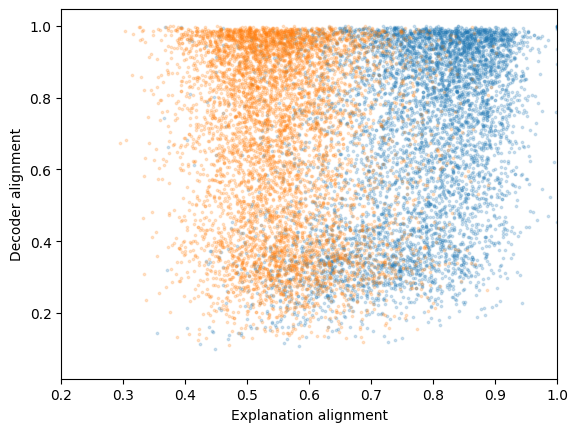

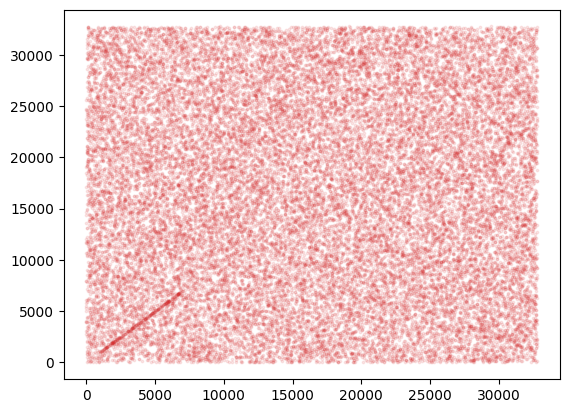

In [137]:
plt.scatter(col_ind_skips,col_ind_dec,s=3,alpha=0.1,c="C3")

In [119]:
cost_diagonal_aligned_non_zero = cost_diagonal_aligned[cost_diagonal_aligned > 0]
cost_diagonal_not_aligned_non_zero = cost_diagonal_not_aligned[cost_diagonal_not_aligned > 0]

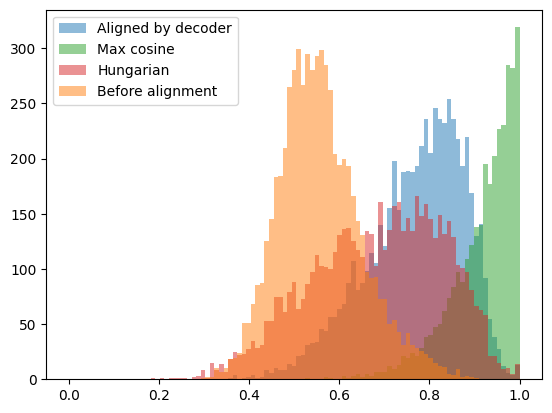

In [122]:
plt.hist(cost_diagonal_aligned_non_zero,bins=np.linspace(0,1,100),color="C0",alpha=0.5,label="Aligned by decoder")
plt.hist(actual_max_cosine,bins=np.linspace(0,1,100),color="C2",alpha=0.5,label="Max cosine")
plt.hist(non_zero_hungarian,bins=np.linspace(0,1,100),color="C3",alpha=0.5,label="Hungarian")
plt.hist(cost_diagonal_not_aligned_non_zero,bins=np.linspace(0,1,100),color="C1",alpha=0.5,label="Before alignment")
plt.legend()

Text(0.5, 0, 'Explanation alignment')

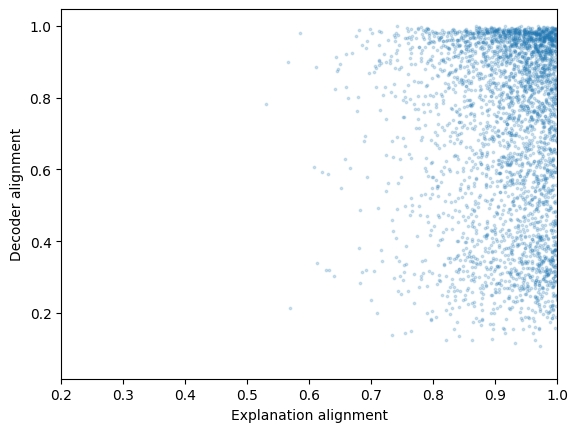

In [135]:
#plt.scatter(cost_diagonal_aligned,cost_dec[row_ind_dec,col_ind_dec],s=3,alpha=0.2,c="C0")
#plt.scatter(cost_diagonal_not_aligned,cost_dec[row_ind_dec,col_ind_dec],s=3,alpha=0.2,c="C1")
#plt.scatter(cost_embeddings_aligned_hungarian,cost_dec[row_ind_dec,col_ind_dec],s=3,alpha=0.2,c="C3")
plt.scatter(cost_embeddings_max_cosine,cost_dec[row_ind_dec,col_ind_dec],s=3,alpha=0.2,c="C0")
plt.ylabel("Decoder alignment")
plt.xlim(0.2,1)
plt.xlabel("Explanation alignment")

# Sizes

In [8]:
row_ind_dec_32,indices_dec_32 = pickle.load(open("alignment/indices_decoder_k32-sae-mlp-32.pkl","rb"))[0][6]
row_ind_enc_32,indices_enc_32 = pickle.load(open("alignment/indices_encoder_k32-sae-mlp-32.pkl","rb"))[0][6]
row_ind_dec_768,indices_dec_768 = pickle.load(open("alignment/indices_decoder_k32-sae-mlp-768.pkl","rb"))[6][6]
row_ind_enc_768,indices_enc_768 = pickle.load(open("alignment/indices_encoder_k32-sae-mlp-768.pkl","rb"))[6][6]
row_ind_dec_4k,indices_dec_4k = pickle.load(open("alignment/indices_decoder_k32-sae-mlp-4k.pkl","rb"))[6][6]
row_ind_enc_4k,indices_enc_4k = pickle.load(open("alignment/indices_encoder_k32-sae-mlp-4k.pkl","rb"))[6][6]
row_ind_dec_32k,indices_dec_32k = pickle.load(open("alignment/indices_decoder_k32-sae-mlp-32k-seed1-seed2.pkl","rb"))[6][6]
row_ind_enc_32k,indices_enc_32k = pickle.load(open("alignment/indices_encoder_k32-sae-mlp-32k-seed1-seed2.pkl","rb"))[6][6]
row_ind_dec_131k,indices_dec_131k = pickle.load(open("alignment/indices_decoder_131k-mlp.pkl","rb"))[0]["SAE 2"]
row_ind_enc_131k,indices_enc_131k = pickle.load(open("alignment/indices_encoder_131k-mlp.pkl","rb"))[0]["SAE 2"]


In [9]:
row_ind_dec_exp36,indices_dec_exp36 = pickle.load(open("alignment/indices_decoder_k32-pythia-exp36-mlp.pkl","rb"))[0][6]
row_ind_enc_exp36,indices_enc_exp36 = pickle.load(open("alignment/indices_encoder_k32-pythia-exp36-mlp.pkl","rb"))[0][6]

In [10]:

sae_32_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32", "layers.6.mlp", "cuda:6")
sae_32_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32-seed2", "layers.6.mlp", "cuda:6")

sae_768_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-768", "layers.6.mlp", "cuda:6")
sae_768_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-768-seed2", "layers.6.mlp", "cuda:6")

sae_4k_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-4k", "layers.6.mlp", "cuda:6")
sae_4k_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-4k-seed2", "layers.6.mlp", "cuda:6")

sae_dir = "EleutherAI/sae-pythia-160m-32k"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-seed2"

sae_32k_seed1 = load_sae(sae_dir, "layers.6.mlp", "cuda:6")
sae_32k_seed2 = load_sae(sae_2_seed_dir, "layers.6.mlp", "cuda:6")

sae_131k_seed1 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-131k", "layers.6.mlp", "cuda:7")
sae_131k_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-131k-seed2", "layers.6.mlp", "cuda:7")


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


In [11]:
sae_exp36 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-exp36", "layers.6.mlp", "cuda:6")
sae_exp36_seed2 = load_sae("/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-exp36-seed2", "layers.6.mlp", "cuda:6")


In [26]:
cost_exp36_dec = sae_exp36.W_dec.data @ sae_exp36_seed2.W_dec.data.T
cost_exp36_enc = (sae_exp36.encoder.weight/sae_exp36.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_exp36_seed2.encoder.weight/sae_exp36_seed2.encoder.weight.norm(dim=1,keepdim=True)).T


cost_exp36_dec = cost_exp36_dec.cpu().detach().numpy()
cost_exp36_enc = cost_exp36_enc.cpu().detach().numpy()


In [12]:
cost_32_dec = sae_32_seed1.W_dec.data @ sae_32_seed2.W_dec.data.T
cost_32_enc = (sae_32_seed1.encoder.weight/sae_32_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_32_seed2.encoder.weight/sae_32_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_768_dec = sae_768_seed1.W_dec.data @ sae_768_seed2.W_dec.data.T
cost_768_enc = (sae_768_seed1.encoder.weight/sae_768_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_768_seed2.encoder.weight/sae_768_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_4k_dec = sae_4k_seed1.W_dec.data @ sae_4k_seed2.W_dec.data.T
cost_4k_enc = (sae_4k_seed1.encoder.weight/sae_4k_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_4k_seed2.encoder.weight/sae_4k_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_32k_dec = sae_32k_seed1.W_dec.data @ sae_32k_seed2.W_dec.data.T
cost_32k_enc = (sae_32k_seed1.encoder.weight/sae_32k_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_32k_seed2.encoder.weight/sae_32k_seed2.encoder.weight.norm(dim=1,keepdim=True)).T


cost_32_dec = cost_32_dec.cpu().detach().numpy()
cost_768_dec = cost_768_dec.cpu().detach().numpy()
cost_4k_dec = cost_4k_dec.cpu().detach().numpy()
cost_32k_dec = cost_32k_dec.cpu().detach().numpy()

cost_32_enc = cost_32_enc.cpu().detach().numpy()
cost_768_enc = cost_768_enc.cpu().detach().numpy()
cost_4k_enc = cost_4k_enc.cpu().detach().numpy()
cost_32k_enc = cost_32k_enc.cpu().detach().numpy()



In [19]:
batch_size = 8192  # Adjust batch size based on available memory
n_batches = (sae_131k_seed1.W_dec.data.shape[0] + batch_size - 1) // batch_size
cost_131k_dec = torch.zeros(sae_131k_seed1.W_dec.data.shape[0], sae_131k_seed2.W_dec.data.shape[0], device="cpu")

for i in tqdm(range(n_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, sae_131k_seed1.W_dec.data.shape[0])
    value = sae_131k_seed1.W_dec.data[start_idx:end_idx] @ sae_131k_seed2.W_dec.data.T
    cost_131k_dec[start_idx:end_idx] = value.cpu()


    

100%|██████████| 16/16 [00:30<00:00,  1.89s/it]


In [20]:
cost_131k_enc = torch.zeros(sae_131k_seed1.encoder.weight.shape[0], sae_131k_seed2.encoder.weight.shape[0], device="cpu")
sae_131k_seed1_encoder_normed = sae_131k_seed1.encoder.weight/sae_131k_seed1.encoder.weight.norm(dim=1,keepdim=True)
sae_131k_seed2_encoder_normed = sae_131k_seed2.encoder.weight/sae_131k_seed2.encoder.weight.norm(dim=1,keepdim=True)
for i in tqdm(range(n_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, sae_131k_seed1.encoder.weight.shape[0])
    value = sae_131k_seed1_encoder_normed[start_idx:end_idx] @ sae_131k_seed2_encoder_normed.T
    cost_131k_enc[start_idx:end_idx] = value.cpu()

100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


In [21]:
cost_131k_dec = cost_131k_dec.cpu().detach().numpy()
cost_131k_enc = cost_131k_enc.cpu().detach().numpy()


In [22]:
mask_32 = cost_32_dec[row_ind_dec_32,indices_dec_32] > 0.7
other_mask_32 = cost_32_enc[row_ind_enc_32,indices_enc_32] > 0.7
max_cosine_32 = np.max(cost_32_dec,axis=1) > 0.7
threshold_32 = sum(mask_32 & other_mask_32)/len(indices_dec_32)
equal_32 = sum(indices_dec_32 == indices_enc_32)/len(indices_dec_32)
average_cost_32_dec = np.mean(cost_32_dec[row_ind_dec_32,indices_dec_32])
average_cost_32_enc = np.mean(cost_32_enc[row_ind_enc_32,indices_enc_32])
max_cosine_enc_32 = np.max(cost_32_enc,axis=1) > 0.7
average_max_cosine_32 = np.mean(np.max(cost_32_dec,axis=1))
average_max_cosine_enc_32 = np.mean(np.max(cost_32_enc,axis=1))
print(threshold_32)
print(equal_32)
max_cosine_32 = max_cosine_32 & max_cosine_enc_32
print(sum(max_cosine_32)/len(max_cosine_32))

0.8125
1.0
0.8125


In [23]:
mask_768 = cost_768_dec[row_ind_dec_768,indices_dec_768] > 0.7
other_mask_768 = cost_768_enc[row_ind_enc_768,indices_enc_768] > 0.7
threshold_768 = sum(mask_768 & other_mask_768)/len(indices_dec_768)
equal_768 = sum(indices_dec_768==indices_enc_768)/len(indices_dec_768)
max_cosine_768 = np.max(cost_768_dec,axis=1) > 0.7
max_cosine_enc_768 = np.max(cost_768_enc,axis=1) > 0.7
max_cosine_768 = max_cosine_768 & max_cosine_enc_768
average_cost_768_dec = np.mean(cost_768_dec[row_ind_dec_768,indices_dec_768])
average_cost_768_enc = np.mean(cost_768_enc[row_ind_enc_768,indices_enc_768])
average_max_cosine_768 = np.mean(np.max(cost_768_dec,axis=1))
average_max_cosine_enc_768 = np.mean(np.max(cost_768_enc,axis=1))
print(threshold_768)
print(equal_768)
print(sum(max_cosine_768)/len(max_cosine_768))

0.78515625
0.94921875
0.7864583333333334


In [24]:
mask_4k = cost_4k_dec[row_ind_dec_4k,indices_dec_4k] > 0.7
other_mask_4k = cost_4k_enc[row_ind_enc_4k,indices_enc_4k] > 0.7
threshold_4k = sum(mask_4k & other_mask_4k)/len(indices_dec_4k)
equal_4k = sum(indices_dec_4k==indices_enc_4k)/len(indices_dec_4k)
max_cosine_4k = np.max(cost_4k_dec,axis=1) > 0.7
max_cosine_enc_4k = np.max(cost_4k_enc,axis=1) > 0.7
max_cosine_4k = max_cosine_4k & max_cosine_enc_4k
average_cost_4k_dec = np.mean(cost_4k_dec[row_ind_dec_4k,indices_dec_4k])
average_cost_4k_enc = np.mean(cost_4k_enc[row_ind_enc_4k,indices_enc_4k])
average_max_cosine_4k = np.mean(np.max(cost_4k_dec,axis=1))
average_max_cosine_enc_4k = np.mean(np.max(cost_4k_enc,axis=1))
print(threshold_4k)
print(equal_4k)
print(sum(max_cosine_4k)/len(max_cosine_4k))

0.69564152791381
0.9162585700293829
0.6983349657198825


In [27]:
mask_exp36 = cost_exp36_dec[row_ind_dec_exp36,indices_dec_exp36] > 0.7
other_mask_exp36 = cost_exp36_enc[row_ind_enc_exp36,indices_enc_exp36] > 0.7
threshold_exp36 = sum(mask_exp36 & other_mask_exp36)/len(indices_dec_exp36)
equal_exp36 = sum(indices_dec_exp36==indices_enc_exp36)/len(indices_dec_exp36)
print(threshold_exp36)
print(equal_exp36)
max_cosine_exp36 = np.max(cost_exp36_dec,axis=1) > 0.7
max_cosine_enc_exp36 = np.max(cost_exp36_enc,axis=1) > 0.7
max_cosine_exp36 = max_cosine_exp36 & max_cosine_enc_exp36
print(sum(max_cosine_exp36)/len(max_cosine_exp36))
average_cost_exp36_dec = np.mean(cost_exp36_dec[row_ind_dec_exp36,indices_dec_exp36])
average_cost_exp36_enc = np.mean(cost_exp36_enc[row_ind_enc_exp36,indices_enc_exp36])
average_max_cosine_exp36 = np.mean(np.max(cost_exp36_dec,axis=1))
average_max_cosine_enc_exp36 = np.mean(np.max(cost_exp36_enc,axis=1))
print(average_cost_exp36_dec)
print(average_cost_exp36_enc)
print(average_max_cosine_exp36)


0.4345703125
0.8048683449074074
0.43898292824074076
0.68762773
0.60595477
0.71619517


In [28]:
mask_32k = cost_32k_dec[row_ind_dec_32k,indices_dec_32k] > 0.7
other_mask_32k = cost_32k_enc[row_ind_enc_32k,indices_enc_32k] > 0.7
threshold_32k = sum(mask_32k & other_mask_32k)/len(indices_dec_32k)
equal_32k = sum(indices_dec_32k==indices_enc_32k)/len(indices_dec_32k)
print(threshold_32k)
print(equal_32k)
max_cosine_32k = np.max(cost_32k_dec,axis=1) > 0.7
max_cosine_enc_32k = np.max(cost_32k_enc,axis=1) > 0.7
max_cosine_32k = max_cosine_32k & max_cosine_enc_32k
print(sum(max_cosine_32k)/len(max_cosine_32k))
average_cost_32k_dec = np.mean(cost_32k_dec[row_ind_dec_32k,indices_dec_32k])
average_cost_32k_enc = np.mean(cost_32k_enc[row_ind_enc_32k,indices_enc_32k])
average_max_cosine_32k = np.mean(np.max(cost_32k_dec,axis=1))
average_max_cosine_enc_32k = np.mean(np.max(cost_32k_enc,axis=1))
print(average_cost_32k_dec)
print(average_cost_32k_enc)
print(average_max_cosine_32k)


0.4158935546875
0.792938232421875
0.4208984375
0.6770369
0.59406924
0.7046474


In [29]:
mask_131k = cost_131k_dec[row_ind_dec_131k,indices_dec_131k] > 0.7
other_mask_131k = cost_131k_enc[row_ind_enc_131k,indices_enc_131k] > 0.7
threshold_131k = sum(mask_131k & other_mask_131k)/len(indices_dec_131k)
equal_131k = sum(indices_dec_131k==indices_enc_131k)/len(indices_dec_131k)
print(threshold_131k)
print(equal_131k)
max_cosine_131k = np.max(cost_131k_dec,axis=1) > 0.7
max_cosine_enc_131k = np.max(cost_131k_enc,axis=1) > 0.7
max_cosine_131k = max_cosine_131k & max_cosine_enc_131k
average_cost_131k_dec = np.mean(cost_131k_dec[row_ind_dec_131k,indices_dec_131k])
average_cost_131k_enc = np.mean(cost_131k_enc[row_ind_enc_131k,indices_enc_131k])
average_max_cosine_131k = np.mean(np.max(cost_131k_dec,axis=1))
average_max_cosine_enc_131k = np.mean(np.max(cost_131k_enc,axis=1))
print(average_cost_131k_dec)
print(average_cost_131k_enc)
print(average_max_cosine_131k)
print(sum(max_cosine_131k)/len(max_cosine_131k))

0.27581024169921875
0.7018966674804688
0.60308206
0.521691
0.634074
0.28203582763671875


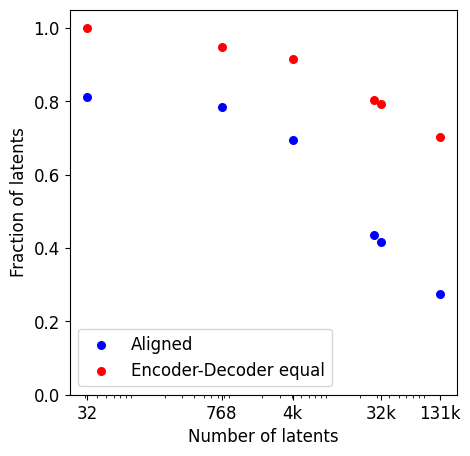

In [30]:
thresholds = [threshold_32,threshold_768,threshold_4k,threshold_exp36,threshold_32k,threshold_131k]
equal = [equal_32,equal_768,equal_4k,equal_exp36,equal_32k,equal_131k]
max_cosines = [sum(max_cosine_32)/len(max_cosine_32),sum(max_cosine_768)/len(max_cosine_768),sum(max_cosine_4k)/len(max_cosine_4k),sum(max_cosine_exp36)/len(max_cosine_exp36),sum(max_cosine_32k)/len(max_cosine_32k),sum(max_cosine_131k)/len(max_cosine_131k)]
size = [32,768,4096,36*768,32768,131072]
plt.figure(figsize=(5,5))
plt.scatter(size,thresholds,s=30,alpha=1,color="blue",label="Aligned")
plt.scatter(size,equal,s=30,alpha=1,color="red",label="Encoder-Decoder equal")
#plt.scatter(size,max_cosines,s=10,alpha=1,color="green",label="Max cosine similarity")
plt.legend(loc="lower left",fontsize=12)
plt.xscale("log")
plt.xticks([32,768,4096,32768,131072],["32","768","4k","32k","131k"],fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,1.05)
plt.xlabel("Number of latents",fontsize=12)
plt.ylabel("Fraction of latents",fontsize=12)
plt.savefig("sae_overlap_fraction.svg",dpi=300)



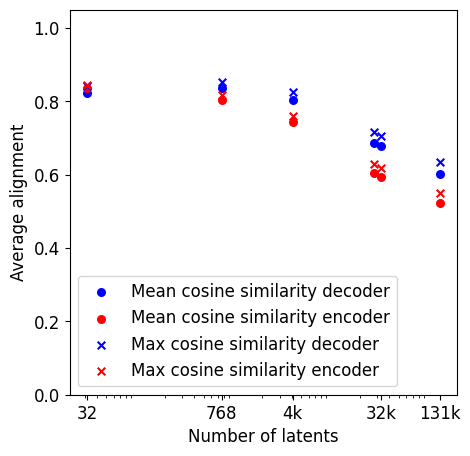

In [63]:
average_dec = [average_cost_32_dec,average_cost_768_dec,average_cost_4k_dec,average_cost_exp36_dec,average_cost_32k_dec,average_cost_131k_dec]
average_enc = [average_cost_32_enc,average_cost_768_enc,average_cost_4k_enc,average_cost_exp36_enc,average_cost_32k_enc,average_cost_131k_enc]
average_max_cosines = [average_max_cosine_32,average_max_cosine_768,average_max_cosine_4k,average_max_cosine_exp36,average_max_cosine_32k,average_max_cosine_131k]
average_max_cosines_enc = [average_max_cosine_enc_32,average_max_cosine_enc_768,average_max_cosine_enc_4k,average_max_cosine_enc_exp36,average_max_cosine_enc_32k,average_max_cosine_enc_131k]
size = [32,768,4096,36*768,32768,131072]
plt.figure(figsize=(5,5))
plt.scatter(size,average_dec,s=30,alpha=1,color="blue",label="Mean cosine similarity decoder")
plt.scatter(size,average_enc,s=30,alpha=1,color="red",label="Mean cosine similarity encoder")
plt.scatter(size,average_max_cosines,s=30,alpha=1,color="blue",label="Max cosine similarity decoder",marker="x")
plt.scatter(size,average_max_cosines_enc,s=30,alpha=1,color="red",label="Max cosine similarity encoder",marker="x")
plt.legend(loc="lower left",fontsize=12)
plt.xscale("log")
plt.xticks([32,768,4096,32768,131072],["32","768","4k","32k","131k"],fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,1.05)
plt.xlabel("Number of latents",fontsize=12)
plt.ylabel("Average alignment",fontsize=12)
plt.savefig("sae_fraction_cosine.svg",dpi=300)



# Training time


In [64]:
row_encoder_short,indices_encoder_short = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-sae-mlp-32k-short.pkl","rb"))[0][6]
row_decoder_short,indices_decoder_short = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-sae-mlp-32k-short.pkl","rb"))[0][6]
sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-short"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-short-seed2"
sae_seed1 = load_sae(sae_dir, f"layers.6.mlp", "cuda:6")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.6.mlp", "cuda:6")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec_short = cost_dec.cpu().detach().numpy()
cost_enc_short = cost_enc.cpu().detach().numpy()

In [65]:
row_encoder_long,indices_encoder_long = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-sae-mlp-32k-long.pkl","rb"))[0][6]
row_decoder_long,indices_decoder_long = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-sae-mlp-32k-long.pkl","rb"))[0][6]
sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-long"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-long-seed2"
sae_seed1 = load_sae(sae_dir, f"layers.6.mlp", "cuda:6")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.6.mlp", "cuda:6")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec_long = cost_dec.cpu().detach().numpy()
cost_enc_long = cost_enc.cpu().detach().numpy()

In [66]:
threshold_short = cost_dec_short[row_decoder_short,indices_decoder_short] > 0.7
threshold_long = cost_dec_long[row_decoder_long,indices_decoder_long] > 0.7
average_cost_short = np.mean(cost_dec_short[row_decoder_short,indices_decoder_short])
average_cost_long = np.mean(cost_dec_long[row_decoder_long,indices_decoder_long])
equal_short = sum(indices_decoder_short==indices_encoder_short)/len(indices_decoder_short)
equal_long = sum(indices_decoder_long==indices_encoder_long)/len(indices_decoder_long)
other_threshold_short = cost_enc_short[row_encoder_short,indices_encoder_short] > 0.7
other_threshold_long = cost_enc_long[row_encoder_long,indices_encoder_long] > 0.7
other_average_cost_short = np.mean(cost_enc_short[row_encoder_short,indices_encoder_short])
other_average_cost_long = np.mean(cost_enc_long[row_encoder_long,indices_encoder_long])
threshold_short = sum(threshold_short & other_threshold_short)/len(indices_decoder_short)
threshold_long = sum(threshold_long & other_threshold_long)/len(indices_decoder_long)

max_cosine_short = np.mean(np.max(cost_dec_short,axis=1))
max_cosine_long = np.mean(np.max(cost_dec_long,axis=1))
other_max_cosine_short = np.mean(np.max(cost_enc_short,axis=1))
other_max_cosine_long = np.mean(np.max(cost_enc_long,axis=1))

print(threshold_short)

print(threshold_long)

0.0726318359375
0.612091064453125


(0.0, 1.05)

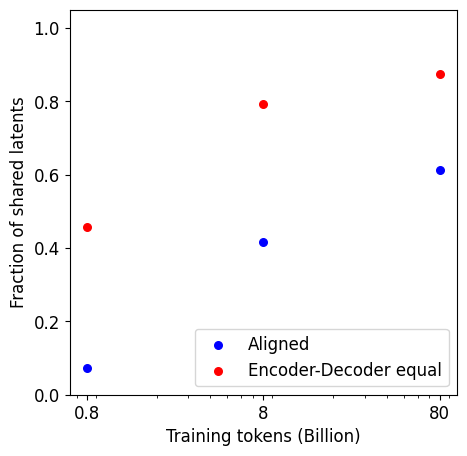

In [67]:
# bar plto with threshold_short, threshold_32k, threshold_long
plt.figure(figsize=(5,5))
plt.scatter([0.8,8,80],[threshold_short,threshold_32k,threshold_long],s=30,alpha=1,color="blue",label="Aligned")
plt.scatter([0.8,8,80],[equal_short,equal_32k,equal_long],s=30,alpha=1,color="red",label="Encoder-Decoder equal")
plt.ylabel("Fraction of shared latents",fontsize=12)
plt.xlabel("Training tokens (Billion)",fontsize=12)
plt.xscale("log")
plt.xticks([0.8,8,80],[0.8,8,80],fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right",fontsize=12)
plt.ylim(0,1.05)
#plt.savefig("sae_overlap_tokens.svg",dpi=300)


In [70]:
max_cosine_32k

array([ True,  True, False, ...,  True,  True,  True])

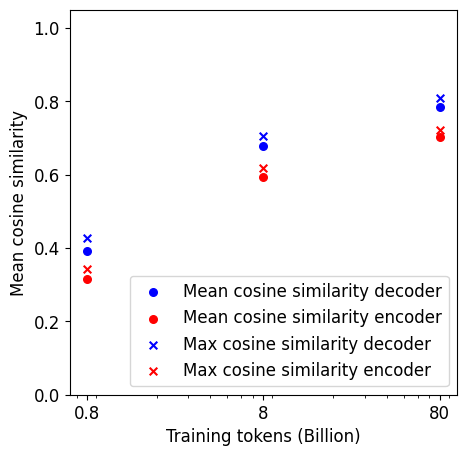

In [72]:
# bar plto with threshold_short, threshold_32k, threshold_long
plt.figure(figsize=(5,5))
plt.scatter([0.8,8,80],[average_cost_short,average_cost_32k_dec,average_cost_long],s=30,alpha=1,color="blue",label="Mean cosine similarity decoder")
plt.scatter([0.8,8,80],[other_average_cost_short,average_cost_32k_enc,other_average_cost_long],s=30,alpha=1,color="red",label="Mean cosine similarity encoder")
plt.scatter([0.8,8,80],[max_cosine_short,average_max_cosine_32k,max_cosine_long],s=30,alpha=1,color="blue",label="Max cosine similarity decoder",marker="x")
plt.scatter([0.8,8,80],[other_max_cosine_short,average_max_cosine_enc_32k,other_max_cosine_long],s=30,alpha=1,color="red",label="Max cosine similarity encoder",marker="x")
plt.ylabel("Mean cosine similarity",fontsize=12)
plt.xlabel("Training tokens (Billion)",fontsize=12)
plt.xscale("log")
plt.xticks([0.8,8,80],[0.8,8,80],fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right",fontsize=12)
plt.ylim(0,1.05)
plt.savefig("sae_tokens_cosine.svg",dpi=300)


# Different K 

In [75]:
ks = [64,128,256]
alignment_k = []
for k in ks:
    #layer 6
    i=6
    row_encoder_k,indices_encoder_k = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k{k}-sae-mlp-32k.pkl","rb"))[0][i]
    row_decoder_k,indices_decoder_k = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k{k}-sae-mlp-32k.pkl","rb"))[0][i]
    sae_dir = f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k{k}-sae-mlp-32k"
    sae_2_seed_dir = f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k{k}-sae-mlp-32k-seed2"
    sae_seed1 = load_sae(sae_dir, f"layers.{i}.mlp", "cuda:6")
    sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}.mlp", "cuda:6")
    cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
    cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
    cost_dec = cost_dec.cpu().detach().numpy()
    cost_enc = cost_enc.cpu().detach().numpy()
    average_cost_mlp_k = np.mean(cost_dec[row_decoder_k,indices_decoder_k])
    other_average_cost_mlp_k = np.mean(cost_enc[row_encoder_k,indices_encoder_k])
    max_cosine_mlp_k = np.mean(np.max(cost_dec,axis=1))
    other_max_cosine_mlp_k = np.mean(np.max(cost_enc,axis=1))
    
    threshold = cost_dec[row_decoder_k,indices_decoder_k] > 0.7
    other_threshold = cost_enc[row_encoder_k,indices_encoder_k] > 0.7
    equal = sum(indices_decoder_k==indices_encoder_k)/len(indices_decoder_k)
    threshold_mlp_k = sum(threshold & other_threshold)/len(indices_decoder_k)
    alignment_k.append({"k":k,"threshold":threshold_mlp_k,"layer":i,"equal":equal,"average_cost":average_cost_mlp_k,"other_average_cost":other_average_cost_mlp_k,"max_cosine":max_cosine_mlp_k,"other_max_cosine":other_max_cosine_mlp_k})



alignment_k.append({"layer":i,"threshold":threshold_32k,"k":32,"equal":equal_32k,"average_cost":average_cost_32k_dec,"other_average_cost":average_cost_32k_enc,"max_cosine":average_max_cosine_32k,"other_max_cosine":average_max_cosine_enc_32k})

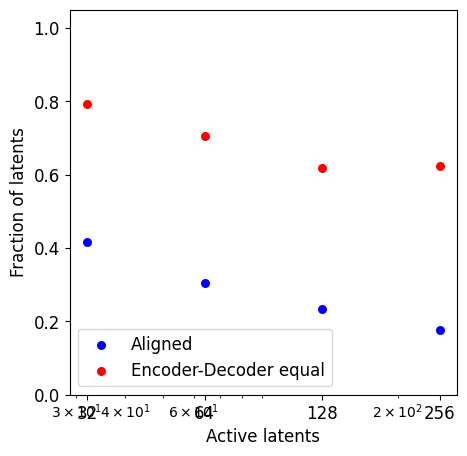

In [31]:
data = pd.DataFrame(alignment_k)
plt.figure(figsize=(5,5))
plt.scatter(data["k"],data["threshold"],s=30,alpha=1,color="blue",label="Aligned")
plt.scatter(data["k"],data["equal"],s=30,alpha=1,color="red",label="Encoder-Decoder equal")
plt.xscale("log")
plt.xticks([32,64,128,256],["32","64","128","256"],fontsize=12,minor=False)
plt.yticks(fontsize=12)
plt.legend(loc="lower left",fontsize=12)
plt.ylim(0,1.05)
plt.ylabel("Fraction of latents",fontsize=12)
plt.xlabel("Active latents",fontsize=12)
plt.savefig("sae_overlap_k.svg",dpi=300)

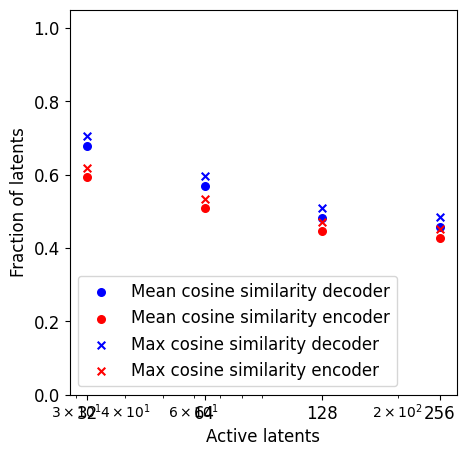

In [76]:
data = pd.DataFrame(alignment_k)
plt.figure(figsize=(5,5))
plt.scatter(data["k"],data["average_cost"],s=30,alpha=1,color="blue",label="Mean cosine similarity decoder")
plt.scatter(data["k"],data["other_average_cost"],s=30,alpha=1,color="red",label="Mean cosine similarity encoder")
plt.scatter(data["k"],data["max_cosine"],s=30,alpha=1,color="blue",label="Max cosine similarity decoder",marker="x")
plt.scatter(data["k"],data["other_max_cosine"],s=30,alpha=1,color="red",label="Max cosine similarity encoder",marker="x")
plt.xscale("log")
plt.xticks([32,64,128,256],["32","64","128","256"],fontsize=12,minor=False)
plt.yticks(fontsize=12)
plt.legend(loc="lower left",fontsize=12)
plt.ylim(0,1.05)
plt.ylabel("Fraction of latents",fontsize=12)
plt.xlabel("Active latents",fontsize=12)
plt.savefig("sae_k_cosine.svg",dpi=300)

# Different layers

In [95]:

aligment_layers = []
sizes = ["k32-sae-mlp-768","k32-sae-mlp-4k"]

for size in sizes:
    for i in range(12):
        sae_seed1 = load_sae(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/{size}", f"layers.{i}.mlp", "cuda:6")
        sae_seed2 = load_sae(f"/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/{size}-seed2", f"layers.{i}.mlp", "cuda:6")
        cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
        cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
        cost_dec = cost_dec.cpu().detach().numpy()
        cost_enc = cost_enc.cpu().detach().numpy()
        _,indices_dec = linear_sum_assignment(cost_dec,maximize=True)
        _,indices_enc = linear_sum_assignment(cost_enc,maximize=True)
        equal = sum(indices_dec==indices_enc)/len(indices_dec)
        threshold = cost_dec[np.arange(len(indices_dec)),indices_dec] > 0.7
        other_threshold = cost_enc[np.arange(len(indices_enc)),indices_enc] > 0.7
        threshold = sum(threshold & other_threshold)/len(indices_dec)
        average_aligment = np.mean(cost_dec[np.arange(len(indices_dec)),indices_dec])
        sae_size = size.split("-")[-1]
        aligment_layers.append({"size":sae_size,"layer":i,"equal":equal,"threshold":threshold,"average_aligment":average_aligment})


In [96]:

for i in range(12):
    _,indices_encoder_32k = pickle.load(open(f"alignment/indices_decoder_k32-sae-mlp-32k-seed1-seed2.pkl","rb"))[i][i]
    _,indices_decoder_32k = pickle.load(open(f"alignment/indices_decoder_k32-sae-mlp-32k-seed1-seed2.pkl","rb"))[i][i]
    sae_dir = "EleutherAI/sae-pythia-160m-32k"
    sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-mlp-32k-seed2"

    sae_seed1 = load_sae(sae_dir, f"layers.{i}.mlp", "cuda:5")
    sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}.mlp", "cuda:5")
    cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
    cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
    cost_dec = cost_dec.cpu().detach().numpy()
    cost_enc = cost_enc.cpu().detach().numpy()
    
    equal = sum(indices_decoder_32k==indices_encoder_32k)/len(indices_decoder_32k)
    threshold = cost_dec[np.arange(len(indices_decoder_32k)),indices_decoder_32k] > 0.7
    other_threshold = cost_enc[np.arange(len(indices_encoder_32k)),indices_encoder_32k] > 0.7
    threshold = sum(threshold & other_threshold)/len(indices_decoder_32k)
    average_aligment = np.mean(cost_dec[np.arange(len(indices_decoder_32k)),indices_decoder_32k])
    aligment_layers.append({"size":"32k","layer":i,"equal":equal,"threshold":threshold,"average_aligment":average_aligment})


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dropping extra args {'signed': False}


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Dropping extra args {'signed': False}


Text(0.5, 0, 'Layer')

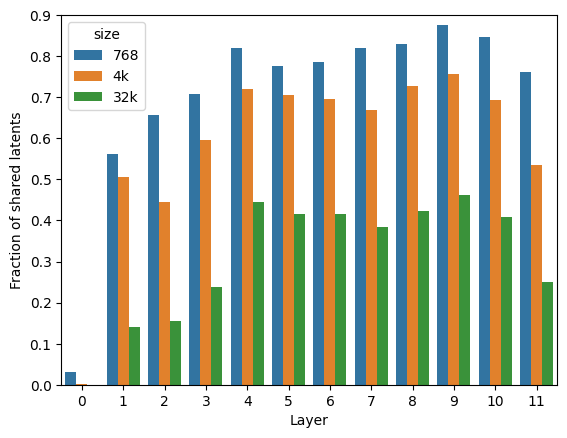

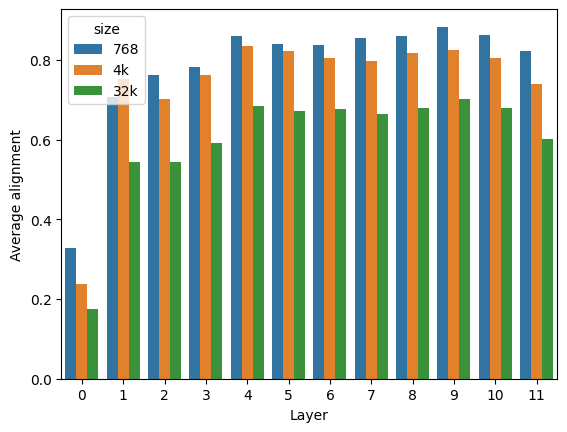

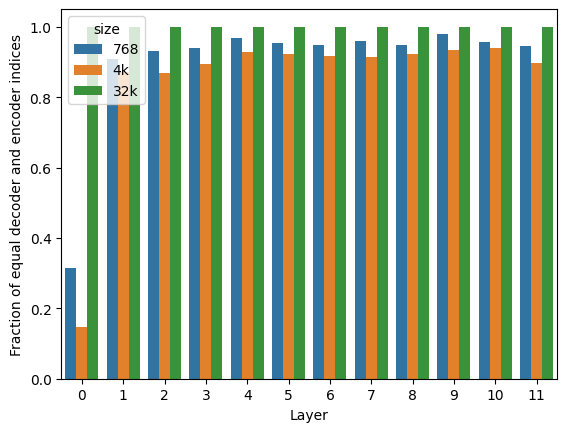

In [97]:
data = pd.DataFrame(aligment_layers)
sns.barplot(data=data,x="layer",y="threshold",hue="size")
plt.ylabel("Fraction of shared latents")
plt.xlabel("Layer")
plt.ylim(0,0.9)
plt.savefig("sae_overlap_32k_layers.svg",dpi=300)
plt.figure()
sns.barplot(data=data,x="layer",y="average_aligment",hue="size")
plt.ylabel("Average alignment")
plt.xlabel("Layer")
plt.figure()
sns.barplot(data=data,x="layer",y="equal",hue="size")
plt.ylabel("Fraction of equal decoder and encoder indices")
plt.xlabel("Layer")



# Different models

In [24]:
all_models = []

In [6]:
sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-smoll-exp36"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-smoll-exp36-seed2"
i=15
#cost res
sae_seed1 = load_sae(sae_dir, f"layers.{i}", "cuda:0")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}", "cuda:0")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T


In [25]:
#layer 15
i=15
rows_encoder_smoll_res,indices_encoder_smoll_res = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-smoll-exp36-res.pkl","rb"))[0][i]
rows_decoder_smoll_res,indices_decoder_smoll_res = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-smoll-exp36-res.pkl","rb"))[0][i]
rows_encoder_smoll_mlp,indices_encoder_smoll_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-smoll-exp36-mlp.pkl","rb"))[0][i]
rows_decoder_smoll_mlp,indices_decoder_smoll_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-smoll-exp36-mlp.pkl","rb"))[0][i]

sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-smoll-exp36"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-smoll-exp36-seed2"

#cost res
sae_seed1 = load_sae(sae_dir, f"layers.{i}", "cuda:0")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}", "cuda:0")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_smoll_res,indices_decoder_smoll_res]
cost_enc = cost_enc.cpu().detach().numpy()[rows_encoder_smoll_res,indices_decoder_smoll_res]

#equal + threshold
#equal_index = indices_encoder_smoll_res==indices_decoder_smoll_res
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
total = sum(cost_dec>0.7)/len(cost_dec)
all_models.append({"equal":total,"Location":"Res","Model":"SmollLLM"})
#cost mlp
sae_seed1 = load_sae(sae_dir, f"layers.{i}.mlp", "cuda:0")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}.mlp", "cuda:0")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_smoll_mlp,indices_decoder_smoll_mlp]
cost_enc = cost_enc.cpu().detach().numpy()[rows_encoder_smoll_mlp,indices_decoder_smoll_mlp]
    
#equal_index = indices_encoder_smoll_mlp==indices_decoder_smoll_mlp
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
total = sum(cost_dec>0.7)/len(cost_dec)

all_models.append({"equal":total,"Location":"MLP","Model":"SmollLLM"})


In [75]:
#layer 6
i=6
rows_encoder_gpt2_res,indices_encoder_gpt2_res = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-gpt2-exp36-res.pkl","rb"))[0][i]
rows_decoder_gpt2_res,indices_decoder_gpt2_res = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-gpt2-exp36-res.pkl","rb"))[0][i]
rows_encoder_gpt2_mlp,indices_encoder_gpt2_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-gpt2-exp36-mlp.pkl","rb"))[0][i]
rows_decoder_gpt2_mlp,indices_decoder_gpt2_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-gpt2-exp36-mlp.pkl","rb"))[0][i]

sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-gpt2-exp36"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-gpt2-exp36-seed2"

#cost res
sae_seed1 = load_sae(sae_dir, f"h.{i}", "cuda:0")
sae_seed2 = load_sae(sae_2_seed_dir, f"h.{i}", "cuda:0")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_gpt2_res,indices_decoder_gpt2_res]
cost_enc = cost_enc.cpu().detach().numpy()[rows_encoder_gpt2_res,indices_decoder_gpt2_res]

#equal + threshold
#equal_index = indices_encoder_gpt2_res==indices_decoder_gpt2_res
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
total = sum(cost_dec>0.7)/len(cost_dec)
all_models.append({"equal":total,"Location":"Res","Model":"GPT2"})
#cost mlp
sae_seed1 = load_sae(sae_dir, f"h.{i}.mlp", "cuda:0")
sae_seed2 = load_sae(sae_2_seed_dir, f"h.{i}.mlp", "cuda:0")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_gpt2_mlp,indices_decoder_gpt2_mlp]
cost_enc = cost_enc.cpu().detach().numpy()[rows_encoder_gpt2_mlp,indices_decoder_gpt2_mlp]

#equal_index = indices_encoder_gpt2_mlp==indices_decoder_gpt2_mlp
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
total = sum(cost_dec>0.7)/len(cost_dec)
all_models.append({"equal":total,"Location":"MLP","Model":"GPT2"})


In [28]:
#layer 16
i=16
rows_encoder_llama_mlp,indices_encoder_llama_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-llama-exp36-mlp.pkl","rb"))[0][i]
rows_decoder_llama_mlp,indices_decoder_llama_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-llama-exp36-mlp.pkl","rb"))[0][i]

sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-llama-mlp-exp36/"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-llama-mlp-exp36-seed2"

#cost mlp
sae_seed1 = load_sae(sae_dir, f"layers.{i}.mlp", "cuda:2")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}.mlp", "cuda:2")
batch_size = 4096  # Adjust batch size based on available memory
n_batches = (sae_seed1.W_dec.data.shape[0] + batch_size - 1) // batch_size
cost_matrix_dec= torch.zeros(sae_seed1.W_dec.data.shape[0], sae_seed2.W_dec.data.shape[0], device="cpu")
cost_matrix_enc = torch.zeros(sae_seed1.encoder.weight.shape[0], sae_seed2.encoder.weight.shape[0], device="cpu")
normalized_encoder = sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)
normalized_encoder_2 = sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)



In [29]:
for i in tqdm(range(n_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, sae_seed1.W_dec.data.shape[0])
    value = sae_seed1.W_dec.data[start_idx:end_idx] @ sae_seed2.W_dec.data.T
    cost_matrix_dec[start_idx:end_idx] = value.cpu()
    value = normalized_encoder[start_idx:end_idx] @ normalized_encoder_2.T
    cost_matrix_enc[start_idx:end_idx] = value.cpu()

cost_dec = cost_matrix_dec.cpu().detach().numpy()[rows_decoder_llama_mlp,indices_decoder_llama_mlp]
cost_enc = cost_matrix_enc.cpu().detach().numpy()[rows_encoder_llama_mlp,indices_encoder_llama_mlp]

#equal_index = indices_encoder_gpt2_mlp==indices_decoder_gpt2_mlp
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
total = sum(cost_dec>0.7)/len(cost_dec)
all_models.append({"equal":total,"Location":"MLP","Model":"LLama"})

100%|██████████| 36/36 [01:45<00:00,  2.93s/it]


In [31]:
max_cos_alignment_dec = cost_matrix_dec.max(dim=1).values.cpu().detach().numpy()
max_cos_alignment_enc = cost_matrix_enc.max(dim=1).values.cpu().detach().numpy()


In [32]:
# line plot with fraction of aligned features depending on the threshold

thresholds = np.linspace(0,1,50)
aligned_features = []
aligned_features_equal = []
max_cosine_sim = []
equal = indices_encoder_llama_mlp==indices_decoder_llama_mlp
for threshold in thresholds:
    # get the features that are higher than the threshold on both the decoder and the encoder
    cost_higher_threshold = cost_dec > threshold
    cost_higher_threshold_enc = cost_enc > threshold
    # get the features that are aligned
    aligned_features_threshold = cost_higher_threshold & cost_higher_threshold_enc
    count_aligned_features_threshold = sum(aligned_features_threshold)
    aligned_features.append(count_aligned_features_threshold/len(indices_decoder_llama_mlp))
    # check also if the features are equal
    aligned_features_equal_threshold = equal & cost_higher_threshold & cost_higher_threshold_enc
    count_aligned_features_equal_threshold = sum(aligned_features_equal_threshold)
    aligned_features_equal.append(count_aligned_features_equal_threshold/len(indices_decoder_llama_mlp))
    # get the max cosine similarity
    cost_max_cos_sim_dec = max_cos_alignment_dec > threshold
    cost_max_cos_sim_enc = max_cos_alignment_enc > threshold
    aligned_features_max_cos_sim = cost_max_cos_sim_dec & cost_max_cos_sim_enc
    count_aligned_features_max_cos_sim = sum(aligned_features_max_cos_sim)
    max_cosine_sim.append(count_aligned_features_max_cos_sim/len(indices_decoder_llama_mlp))




/mnt/ssd-1/gpaulo/miniconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


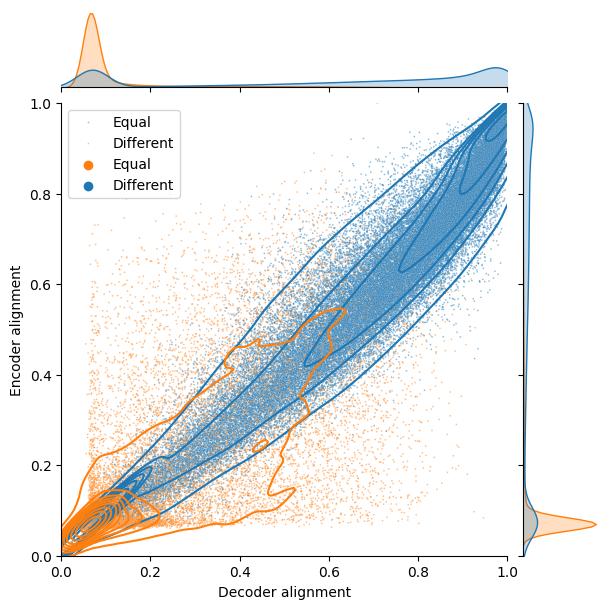

In [25]:
# have a list that says equal in the positions where equal is true and different in the positions where equal is false
equal_list = ["Equal" if e else "Different" for e in equal]


g = sns.jointplot(x=cost_dec,y=cost_enc,hue=equal_list,alpha=0.5,s=1.5)
g.plot_joint(sns.kdeplot,linewidth=2)
plt.scatter(-1,-1,color="C1",label="Equal")
plt.scatter(-1,-1,color="C0",label="Different")

plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.xlabel("Decoder alignment")
plt.ylabel("Encoder alignment")
plt.savefig("equal_llama.svg")

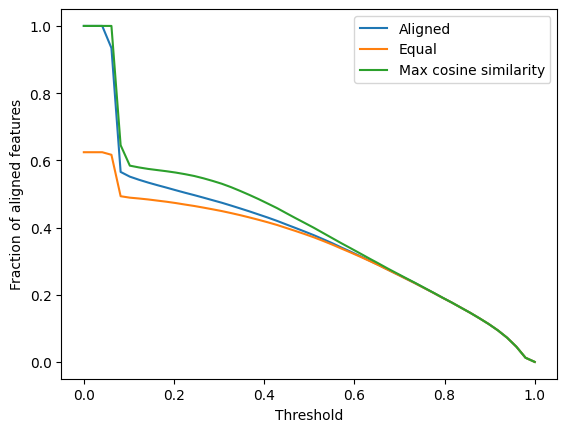

In [33]:
plt.plot(thresholds,aligned_features,label="Aligned")
plt.plot(thresholds,aligned_features_equal,label="Equal")
plt.plot(thresholds,max_cosine_sim,label="Max cosine similarity")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Fraction of aligned features")
plt.savefig("llama_alignment.svg")


(array([ 7863., 40907., 10789.,  2183.,  1192.,   889.,   747.,   654.,
          539.,   474.,   470.,   473.,   430.,   413.,   433.,   429.,
          445.,   437.,   445.,   431.,   446.,   480.,   492.,   488.,
          448.,   514.,   544.,   479.,   516.,   490.,   516.,   543.,
          604.,   538.,   558.,   553.,   610.,   583.,   674.,   614.,
          672.,   626.,   666.,   626.,   666.,   677.,   731.,   749.,
          701.,   760.,   732.,   717.,   755.,   740.,   803.,   820.,
          775.,   822.,   827.,   858.,   880.,   851.,   898.,   848.,
          901.,   875.,   897.,   903.,   929.,   949.,   968.,   930.,
          958.,   956.,  1026.,   976.,  1017.,  1026.,  1047.,  1008.,
         1099.,  1050.,  1133.,  1185.,  1119.,  1167.,  1213.,  1278.,
         1307.,  1326.,  1429.,  1473.,  1558.,  1661.,  1920.,  2152.,
         2592.,  3318.,  3631.,   946.]),
 array([0.05436896, 0.06382412, 0.07327927, 0.08273442, 0.09218958,
        0.10164473, 0.1110

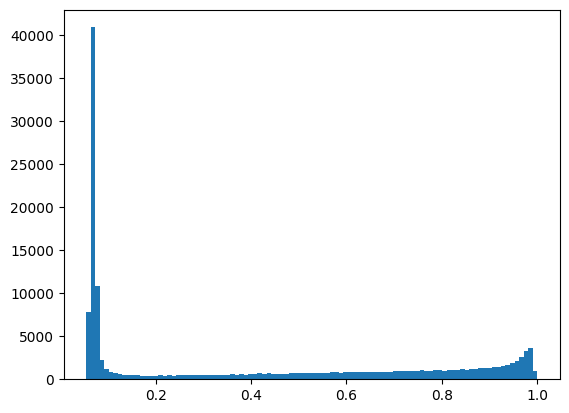

In [35]:
plt.hist((cost_dec+cost_enc)/2,bins=100)

In [30]:
#layer 6
i=6
rows_encoder_pythia_res,indices_encoder_pythia_res = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-pythia-exp36-res.pkl","rb"))[0][i]
rows_decoder_pythia_res,indices_decoder_pythia_res = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-pythia-exp36-res.pkl","rb"))[0][i]
rows_encoder_pythia_mlp,indices_encoder_pythia_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_k32-pythia-exp36-mlp.pkl","rb"))[0][i]
rows_decoder_pythia_mlp,indices_decoder_pythia_mlp = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_k32-pythia-exp36-mlp.pkl","rb"))[0][i]

sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-exp36"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/saes/k32-sae-exp36-seed2"

#cost res
sae_seed1 = load_sae(sae_dir, f"layers.{i}", "cuda:0")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}", "cuda:0")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_pythia_res,indices_decoder_pythia_res]
cost_enc = cost_enc.cpu().detach().numpy()[rows_encoder_pythia_res,indices_decoder_pythia_res]

#equal + threshold
#equal_index = indices_encoder_gpt2_res==indices_decoder_gpt2_res
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
total = sum(cost_dec>0.7)/len(cost_dec)
all_models.append({"equal":total,"Location":"Res","Model":"Pythia"})
#cost mlp
sae_seed1 = load_sae(sae_dir, f"layers.{i}.mlp", "cuda:0")
sae_seed2 = load_sae(sae_2_seed_dir, f"layers.{i}.mlp", "cuda:0")
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.encoder.weight/sae_seed1.encoder.weight.norm(dim=1,keepdim=True)) @ (sae_seed2.encoder.weight/sae_seed2.encoder.weight.norm(dim=1,keepdim=True)).T
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_pythia_mlp,indices_decoder_pythia_mlp]
cost_enc = cost_enc.cpu().detach().numpy()[rows_encoder_pythia_mlp,indices_decoder_pythia_mlp]

#equal_index = indices_encoder_gpt2_mlp==indices_decoder_gpt2_mlp
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
total = sum(cost_dec>0.7)/len(cost_dec)
all_models.append({"equal":total,"Location":"MLP","Model":"Pythia"})


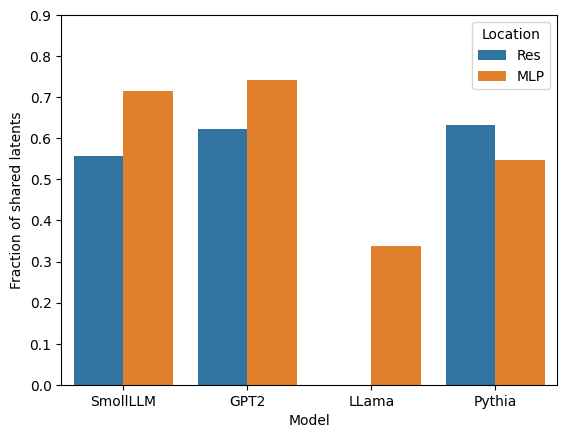

In [92]:
data = pd.DataFrame(all_models)
sns.barplot(data=data,x="Model",y="equal",hue="Location")
plt.ylabel("Fraction of shared latents")
plt.xlabel("Model")
plt.ylim(0,0.9)
plt.savefig("sae_overlap_models.svg",dpi=300)

# Architecture

In [34]:
from sae_lens import SAE

In [65]:
all_archs = []

In [66]:
sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/checkpoints/sae_gated_seed_42_lr_0.0002_coef_3_long.pt"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/checkpoints/sae_gated_seed_123_lr_0.0002_coef_3_long.pt"
#cost res
sae_seed1 = SAE.load_from_pretrained(sae_dir)
sae_seed2 = SAE.load_from_pretrained(sae_2_seed_dir)
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.W_enc.data/sae_seed1.W_enc.data.norm(dim=1,keepdim=True)) @ (sae_seed2.W_enc.data/sae_seed2.W_enc.data.norm(dim=1,keepdim=True)).T
#layer 15
i=6
rows_encoder_gated,indices_encoder_gated = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_gated_3.pkl","rb"))[0][i]
rows_decoder_gated,indices_decoder_gated = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_gated_3.pkl","rb"))[0][i]

#equal + threshold
#equal_index = indices_encoder_smoll_res==indices_decoder_smoll_res
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_gated,indices_decoder_gated]
total = sum(cost_dec>0.7)/len(cost_dec)
all_archs.append({"equal":total,"Architecture":"Gated"})
#cost mlp



/mnt/ssd-1/gpaulo/miniconda3/lib/python3.12/site-packages/sae_lens/sae.py:145: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [67]:

sae_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/checkpoints/sae_standard_seed_42_lr_0.0002_coef_3_long.pt"
sae_2_seed_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/extras/sae_sizes/checkpoints/sae_standard_seed_123_lr_0.0002_coef_3_long.pt"
#cost res
sae_seed1 = SAE.load_from_pretrained(sae_dir)
sae_seed2 = SAE.load_from_pretrained(sae_2_seed_dir)
cost_dec = sae_seed1.W_dec.data @ sae_seed2.W_dec.data.T
cost_enc = (sae_seed1.W_enc.data/sae_seed1.W_enc.data.norm(dim=1,keepdim=True)) @ (sae_seed2.W_enc.data/sae_seed2.W_enc.data.norm(dim=1,keepdim=True)).T
#layer 15
i=6
rows_encoder_l1high,indices_encoder_l1high = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_decoder_standard_3.pkl","rb"))[0][i]
rows_decoder_l1high,indices_decoder_l1high = pickle.load(open(f"/mnt/ssd-1/gpaulo/sae_sizes/sae_overlap/alignment/indices_encoder_standard_3.pkl","rb"))[0][i]

#equal + threshold
#equal_index = indices_encoder_smoll_res==indices_decoder_smoll_res
#threshold = (cost_dec>0.7) & (cost_enc>0.7)
#total = sum(equal_index & threshold)/len(equal_index)
cost_dec = cost_dec.cpu().detach().numpy()[rows_encoder_l1high,indices_decoder_l1high]
total = sum(cost_dec>0.7)/len(cost_dec)
all_archs.append({"equal":total,"Architecture":"L1 High"})
#cost mlp


In [83]:
all_archs.pop(2)


{'equal': 0.0001808449074074074, 'Architecture': 'L1 Low'}

In [84]:
all_archs

[{'equal': 0.8561921296296297, 'Architecture': 'Gated'},
 {'equal': 0.8241464120370371, 'Architecture': 'L1 High'},
 {'equal': 0.7421513310185185, 'Architecture': 'TopK'}]

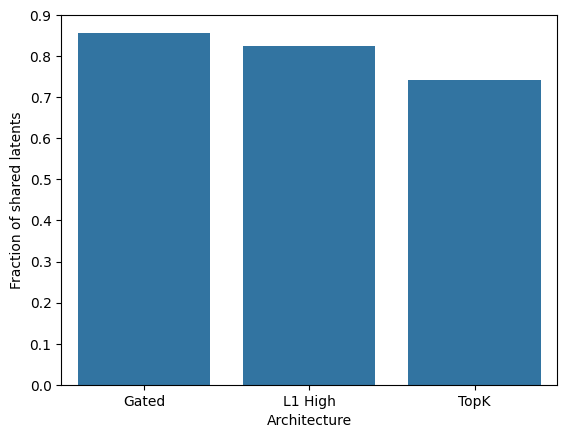

In [94]:
data = pd.DataFrame(all_archs)
sns.barplot(data=data,x="Architecture",y="equal")
plt.ylabel("Fraction of shared latents")
plt.xlabel("Architecture")
plt.ylim(0,0.9)
plt.savefig("sae_overlap_architecture.svg",dpi=300)